In [8]:
import numpy as np
import scipy.io as sio
import datetime
import src.helper_functions as helper
import src.spectra as spectra
from src.mooring import Mooring
from src.location import Location
from src.ctd_cast import CTDCast

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.facecolor":  "white",  
    "savefig.facecolor": "white",  
})

import warnings
import pandas as pd
import gsw
#warnings.filterwarnings("ignore")  # suppress some warnings about future code changes

In [60]:
ONE_COLUMN_WIDTH = 8.3
TWO_COLUMN_WIDTH = 12
GOLDEN_RATIO = 1.61
cm = 1/2.54  # centimeters in inches

# Load Data

In [9]:
ls ../data/CTD

N_values.pkl


In [10]:
# load all 7 moorings as dataframes
list_of_moorings = helper.IO.load_pickle(name="../data/mooring/list_of_moorings.pkl")
# load Stratification information
N_table = pd.read_pickle("../data/CTD/N_values.pkl")

data = np.load("../data/mooring/max_depth_dict.npz", allow_pickle = True)
max_depth_dict = data["max_depth_dict"].item()

In [11]:
# Get CTD Data
columns = ['Event', 'Date/Time', 'Latitude', 'Longitude',
       'Depth water [m]', 'Press [dbar]', 'Temp [°C]', 'Sal', 'Expedition']
CTDs = pd.DataFrame(columns=columns)

#definition of box around the transect 
m = (63.21 - 64.22)/(53.8 - 47)
b = 63.21 - m * 53.8
shift = 0.12

def get_PS129_CTD_data():
    #get location of CTD files from the LADCP data files
    LADCP_DIRECTORY = f"/media/sf_VM_Folder/PS129_Plots/ladcp_profiles/"

    ladcp_paths = sorted(helper.IO.get_filepaths_from_directory(LADCP_DIRECTORY, inclusive = (".mat",)))

    #all CTD cast can be identified by a number
    ladcp_cast_numbers = [path.split('/')[-1][7:-4] for path in ladcp_paths]

    #create list of all CTD cast locations
    ctd_locations = []
    ctd_timestamps = []
    for path in ladcp_paths:
        data_struct = sio.loadmat(path) 
        data = data_struct["dr"][0][0]
        lat = np.round(np.squeeze(data["lat"]),3)
        lon = np.round(np.squeeze(data["lon"]),3)
        ctd_locations.append(Location(lat = lat, lon = lon))
        time_stamp = datetime.datetime(*map(int, np.squeeze(data["date"]))) #convert list of values to datetime object
        ctd_timestamps.append(time_stamp)
        
    # Set up conversion from ID number to cast name    
    def load_stations(path):
        transect_names, transect_numbers = np.loadtxt(path, dtype = (str), delimiter = "\t", unpack = True)
        translate = dict(zip(transect_names, transect_numbers))
        #print(translate)
        return translate
    name_to_number_dict = load_stations("/media/sf_VM_Folder/PS129_Plots/conversion.txt")
    number_to_name_dict = {int(v): k for k, v in name_to_number_dict.items()}    

    #create as many CTDCast objects as casts itself
    list_of_PS129_casts= [CTDCast() for _ in ladcp_cast_numbers]

    # for every cast object set a location and a name
    for i,cast in enumerate(list_of_PS129_casts):
        cast_number = ladcp_cast_numbers[i]
        cast_name = number_to_name_dict[int(cast_number)]
        cast.name = cast_name
        cast.location = ctd_locations[i]
        cast.date = ctd_timestamps[i]

    column_names = ['Event', "Latitude", "Longitude", "Press [dbar]", "Sal", "Temp [°C]", "Absolute Salinity", "Conservative Temperature", "Date/Time", "Depth water [m]", "Expedition"]
    data_dict = {name:[] for name in column_names}

    for cast in list_of_PS129_casts:
        #load actual data to that Cast name
        try:   
            path = f"/media/sf_VM_Folder/PS129_Plots/ctd_profiles/dps129_{cast.name}.cnv"
        
            #SP = Practical Salinity [PSU]
            #Temperature [ITS-90, °C]

            #add the cast data to the data dictionary
            pressure,in_situ_temperature,practical_salinity = np.genfromtxt(path, skip_header = 322, usecols = (0,1,5), unpack = True)
            data_dict["Event"].extend([f"PS129_{cast.name}"] * len(pressure))
            data_dict["Latitude"].extend([cast.location.lat] * len(pressure))
            data_dict["Longitude"].extend([cast.location.lon] * len(pressure))
            data_dict["Press [dbar]"].extend(pressure)
            data_dict["Temp [°C]"].extend(in_situ_temperature)
            data_dict["Sal"].extend(practical_salinity)
            data_dict["Date/Time"].extend([cast.date] * len(pressure))
            data_dict["Expedition"].extend(["PS129"] * len(pressure))
            
            #add new attributes
            SA = gsw.SA_from_SP(SP = practical_salinity, p = pressure, lon = cast.location.lon, lat = cast.location.lat)
            data_dict["Absolute Salinity"].extend(SA)
            data_dict["Conservative Temperature"].extend(gsw.CT_from_t(SA = SA, t = in_situ_temperature, p = pressure))
            data_dict["Depth water [m]"].extend(np.abs(gsw.z_from_p(p = pressure, lat = cast.location.lat)))
        
        except ValueError as e:
            print("Error at ",cast.name, cast.location)
            print(e)
            continue
        #print(cast.name)     
    #print(data_dict)
    #for (k,v) in data_dict.items():
    #    print(k,len(v))
    return pd.DataFrame(data = data_dict)

PS129_CTDs = get_PS129_CTD_data()
CTDs = CTDs.merge(PS129_CTDs, on = columns, how = "outer")
#Drop all rows that are not even close to the moorings
CTDs.drop(CTDs[CTDs.Latitude < -64.5].index, inplace = True)
CTDs.drop(CTDs[CTDs.Latitude > -63].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude < -54].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude > -47].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b+shift < CTDs.Latitude
].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b-shift > CTDs.Latitude 
].index, inplace = True)

CTDs.reset_index(inplace = True, drop=True)

def find_line_number(filename, target_string):
    with open(filename, 'r') as file:
        for line_number, line in enumerate(file):
            if line.startswith(target_string):
                return line_number
    return None

data_paths = helper.IO.get_filepaths_from_directory(directory = "/media/sf_VM_Folder/data/CTD", inclusive = ".tab", exclusive = ())
#for p in data_paths: print(p)

for i, path in enumerate(data_paths):
    target_string = "Event\tDate/Time\tLatitude\tLongitude\tElevation [m]"
    skiprows = find_line_number(path, target_string)
    if skiprows == None:
        target_string = "Event	Type	Date/Time	Longitude"
        skiprows = find_line_number(path, target_string)

    data = pd.read_csv(path, delimiter = "\t", skiprows= skiprows)
    
    data = data[data.columns.intersection(columns)]
    
    #Drop all rows that are not even close to the moorings
    data.drop(data[data.Latitude < -64.5].index, inplace = True)
    data.drop(data[data.Latitude > -63].index, inplace = True)
    data.drop(data[data.Longitude < -54].index, inplace = True)
    data.drop(data[data.Longitude > -47].index, inplace = True)

    data.drop(data[
        m*data.Longitude-b+shift < data.Latitude
    ].index, inplace = True)
    
    data.drop(data[
        m*data.Longitude-b-shift > data.Latitude 
    ].index, inplace = True)
            
    data.reset_index(inplace = True, drop=True)
    
    data['Date/Time'] =  pd.to_datetime(data['Date/Time'])#, format='%d%b%Y:%H:%M:%S.%f')
    data['Event'] = data['Event'].astype('category')
    
    try:
        if data['Event'].iloc[0][4] != "/": 
            current_expedition = data['Event'].iloc[0][0:5]
        else:
            current_expedition = data['Event'].iloc[0][0:4]
        print(current_expedition, path)
        data['Expedition'] = current_expedition
        CTDs = CTDs.merge(data, on = columns, how = "outer")  
        assert not data.empty
    
    except IndexError as e:
        print(f"Error loading {path}")
        assert data.empty
        continue

        
CTDs['Event'] = CTDs['Event'].astype('category')    
CTDs['Expedition'] = CTDs['Expedition'].astype('category')  

CTDs_grouped = CTDs.groupby("Event")
events = CTDs_grouped.groups.keys()

Error at  018_07 (-59.09,0.12)
Some errors were detected !
    Line #323 (got 1 columns instead of 3)
PS18 /media/sf_VM_Folder/data/CTD/ANT-IX_2_phys_oce.tab
PS16 /media/sf_VM_Folder/data/CTD/ANT-VIII_2_phys_oce.tab
PS40 /media/sf_VM_Folder/data/CTD/ANT-XIII_4_phys_oce.tab
Error loading /media/sf_VM_Folder/data/CTD/ANT-XIV_3_phys_oce.tab
PS49 /media/sf_VM_Folder/data/CTD/ANT-XV_4_phys_oce.tab
PS67 /media/sf_VM_Folder/data/CTD/ANT-XXII_3_phys_oce.tab
PS71 /media/sf_VM_Folder/data/CTD/ANT-XXIV_3_phys_oce.tab
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_2_phys_oce.tab
Error loading /media/sf_VM_Folder/data/CTD/ANT-XXIX_3_phys_oce.tab
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_6_phys_oce.tab
PS77 /media/sf_VM_Folder/data/CTD/ANT-XXVII_2_phys_oce.tab
Error loading /media/sf_VM_Folder/data/CTD/ANT-X_4_phys_oce.tab
PS23 /media/sf_VM_Folder/data/CTD/ANT-X_7_phys_oce.tab
PS103 /media/sf_VM_Folder/data/CTD/PS103_phys_oce.tab
PS117 /media/sf_VM_Folder/data/CTD/PS117_phys_oce.tab


# Show Overview

In [12]:
CTDs_grouped = CTDs.groupby("Event")
events = CTDs_grouped.groups.keys()

In [13]:
if False:
    import gsw
    import cartopy.crs as ccrs
    import cartopy.feature 
    import matplotlib.colors as mcolors
    import cmocean as cm
    import gvpy
    
    #projection = ccrs.Orthographic(central_longitude=-50, central_latitude=-80)
    projection = ccrs.SouthPolarStereo(central_longitude=-50)
    #projection = ccrs.PlateCarree()
    # Limit the map to -60 degrees latitude and below.

    fig = plt.figure()
    fig.set_size_inches(8,8)
    ax = fig.add_axes([0, 0, 1, 1], projection= projection)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    ax.set_extent([-54, -46, -63, -64.3], ccrs.PlateCarree())

    file_path = "/media/sf_VM_Folder/data/moorings/supermooring.mat"
    struct = sio.loadmat(file_path)
    data = struct["mooring"]

    #load necessary data into usable variables
    lat_list = np.squeeze(data["LAT"])
    lon_list = np.squeeze(data["LON"])

    # # Load Bathymetry
    #bat_data = sio.loadmat("/media/sf_VM_Folder/data/out.mat") 
    bat_data = sio.loadmat("/media/sf_VM_Folder/data/WeddellSea_Bat.mat") 
    bat_lat = bat_data["lat"]
    bat_lon = bat_data["lon"]
    bat_z = bat_data["z"]

    #ax.set_title("Mooring Locations in the Weddell Sea, Antarctica")
    divnorm = mcolors.TwoSlopeNorm(vcenter=0)
    #image = plt.contourf(bat_lon, bat_lat, bat_z, 60,transform=ccrs.PlateCarree(), cmap = cm.cm.topo, norm=divnorm)#, vmax = 300, vmin = -3500)
    image = ax.contourf(bat_lon, bat_lat, bat_z, 20,transform=ccrs.PlateCarree(), cmap = cm.cm.topo, norm=divnorm, vmax = 3000, vmin = -5000)
    
    plt.colorbar(image, ax = ax, orientation = "horizontal", shrink=0.5)
    
    ax.contour(bat_lon, bat_lat, bat_z, 20, linewidths=0.5, linestyles='solid', colors=['black'], alpha=0.4, vmax = 3000, vmin = -5000, transform=ccrs.PlateCarree())

    fig.tight_layout()

    color = "grey"
    markersize = 20  
    
    for event in events:
        profile = CTDs_grouped .get_group(event).reset_index(drop = True)
        ax.plot(profile["Longitude"].iloc[0],
                profile["Latitude"].iloc[0],
                ".",
                markersize = markersize,
                color = color,
                markeredgewidth=1,
                markeredgecolor = "black",
                transform=ccrs.PlateCarree())

    for mooring in list_of_moorings:
        ax.plot(mooring.location.lon, mooring.location.lat, "kD", markersize = 10 , transform = ccrs.PlateCarree(), zorder = 12)

        
    gvpy.maps.cartopy_scale_bar(ax, location = (0.3,0.1), length = 100) 
    fig.tight_layout()
    fig.savefig("figures/overview_map.png", dpi = 300)    


In [14]:
from IPython.display import Image, display;   
#display(Image(filename='./figures/overview_map.png', width = 600))

In [15]:
ls ./figures/

ls: cannot access './figures/': No such file or directory


# Select Example Mooring

In [16]:
mooring = list_of_moorings[1]
print(f"{mooring.location = }, {mooring.time_delta = }")

mooring.location = Location(lat=-63.5145, lon=-51.6357), mooring.time_delta = Timedelta('0 days 01:59:59.999999999')


In [17]:
mooring

,time,1318,1513,1625
0,2017-01-26 19:49:59.999999,-0.0191+0.1397j,0.0047+0.2066j,0.0084+0.1408j
1,2017-01-26 21:50:00.000002,-0.0681+0.1867j,-0.0616+0.2733j,0.0284+0.2470j
2,2017-01-26 23:49:59.999996,-0.0856+0.1558j,-0.0816+0.2237j,-0.0140+0.3139j
3,2017-01-27 01:49:59.999999,-0.0543+0.0920j,-0.0398+0.1625j,-0.0232+0.2475j
4,2017-01-27 03:50:00.000002,-0.0392+0.0517j,-0.0195+0.0944j,0.0104+0.1748j
...,...,...,...,...
8791,2019-01-29 09:50:00.000002,0.0109+0.0425j,-0.0008+0.1042j,N000000a000000N
8792,2019-01-29 11:49:59.999996,0.0121+0.0744j,0.0271+0.1276j,N000000a000000N
8793,2019-01-29 13:49:59.999999,-0.0031+0.0963j,0.0299+0.1779j,N000000a000000N
8794,2019-01-29 15:50:00.000002,-0.0223+0.1233j,0.0054+0.2381j,N000000a000000N


In [18]:
measurement_depth  =  "1513"#mooring.oze.get_shallowest_time_series().name
measurement_depth

'1513'

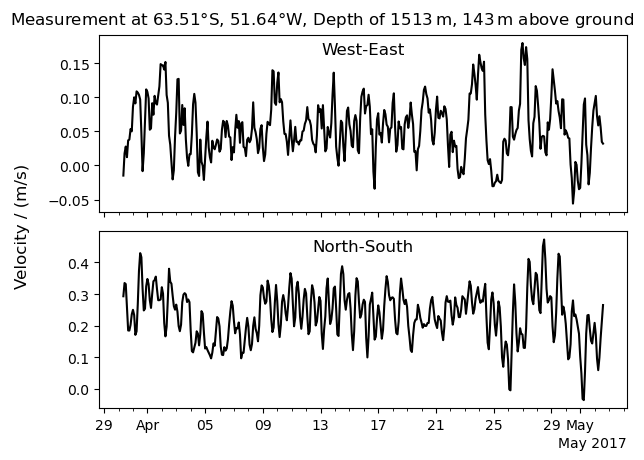

In [19]:
import matplotlib.dates as mdates

cv = mooring[str(measurement_depth)].to_numpy()
time = mooring["time"].to_numpy()

fig, axis = plt.subplots(2, sharex = True)#, figsize = (6.4,4.8))

#print(np.shape(cv))
time = time[750:1150]
cv = cv[750:1150]

axis[0].plot(time, np.real(cv),"k")
axis[1].plot(time, np.imag(cv),"k")

#axis[0].set_ylabel("$u$ velocity / (m/s)")
#axis[1].set_ylabel("$v$ velocity / (m/s)")

Fmt = mdates.DateFormatter("%d.%m.%Y")
#axis[1].xaxis.set_major_formatter(Fmt)

#formatter = mdates.ConciseDateFormatter(axis[1].xaxis.get_major_locator())
#formatter.offset_formats = ['%Y']
#axis[1].xaxis.set_major_formatter(formatter)


#Set the minor tick frequency to every day
axis[1].xaxis.set_minor_locator(mdates.DayLocator())

    
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
formatter.formats = ['%y',  # ticks are mostly years
                     '%b',       # ticks are mostly months
                     '%d',       # ticks are mostly days
                     '%H:%M',    # hrs
                     '%H:%M',    # min
                     '%S.%f', ]  # secs
# these are mostly just the level above...
formatter.zero_formats = [''] + formatter.formats[:-1]
# ...except for ticks that are mostly hours, then it is nice to have
# month-day:
formatter.zero_formats[3] = '%d-%b'

formatter.offset_formats = ['',
                            '%Y',
                            '%b %Y',
                            '%d %b %Y',
                            '%d %b %Y',
                            '%d %b %Y %H:%M', ]
axis[1].xaxis.set_major_locator(locator)
axis[1].xaxis.set_major_formatter(formatter)

fig.suptitle(f"Measurement at {mooring.location.pretty_print()}, Depth of {measurement_depth}$\,$m, {143}$\,$m above ground", y=0.95)

axis[0].set_title('West-East', y=1.0, pad=-14, ha = "center")
axis[1].set_title('North-South', y=1.0, pad=-14, ha = "center")


#plt.xlabel("common X")
fig.supylabel('Velocity / (m/s)')

fig.tight_layout()

# Compute Velocity Spectra

In [20]:
TIME_BANDWIDTH_PRODUCT = 10

Start out with the shallowest measurement

In [21]:
complex_velocity = mooring[measurement_depth]
complex_velocity_array = helper.Data.cut_trailing_nans(
    complex_velocity.to_numpy()
)
freq, velocity_spectrum = spectra.total_multitaper(
    complex_velocity_array, dt=1 / 12, P=TIME_BANDWIDTH_PRODUCT
)
assert not np.any(np.isnan(velocity_spectrum))

The multitaper routine calculates a twosided spectrum, with negative frequencies being the clockwise and the positive being the counterclockwise rotation. 

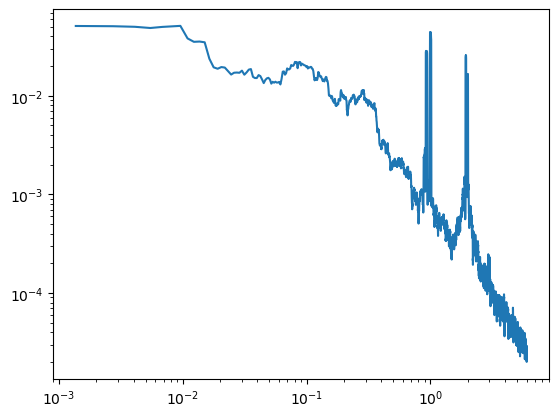

In [22]:
plt.loglog(freq, velocity_spectrum)

### Check normalization

The integral over the velocity spectrum should be equal to the variance $\sigma^2$ of the complex velocity measurement $\vec{u} = u + iv$.

\begin{equation}
    \int psd(\nu) d\nu = \text{Var}({\vec{u}})
\end{equation}

In [23]:
def integrate_psd_interval(freq,psd,a = 0,b = 99):
    """
    Integration between a und b using the trapezoidal integration method
    """
    lower = np.argmin(np.abs(freq-a)).astype(int)
    upper = np.argmin(np.abs(freq-b)).astype(int)
    return np.trapz(y = psd[lower:upper], x = freq[lower:upper]) 

print(f"integrated spectrum =\t{integrate_psd_interval(freq,velocity_spectrum):.6e}")
print(f"var(uv) =\t\t{np.var(complex_velocity_array):.3e}")

integrated spectrum =	9.988313e-03
var(uv) =		1.005e-02


To get the interpretation of horizontal kinetic energy per frequency range, we have to divide the spectrum by 2

In [24]:
kinetic_psd = velocity_spectrum/2

In [25]:
u = np.real(complex_velocity_array)
v = np.imag(complex_velocity_array)

# mean removal
u -= np.mean(u)
v -= np.mean(v)
print(f"integrated spectrum =\t{integrate_psd_interval(freq,kinetic_psd):.3e}")
print(f"1/2 |u+iv|^2 =\t{0.5*np.mean(np.abs(complex_velocity_array)**2):.3e}")

integrated spectrum =	4.994e-03
1/2 |u+iv|^2 =	5.023e-03


Not bad until now, but we can add context to the plot, like ...

### Adding tidal frequencies

In [26]:
TIDAL_CONSTITUENTS = {"M2": 12.42, "S2": 12.00, "N2":12.66, "K2": 11.96, "K1": 23.93, "O1": 25.82, "P1":24.07, "Q1":26.87}
print(TIDAL_CONSTITUENTS)
# sort the constituents in descending order after their tidal periods
# This is important for finding overlapping tidal peaks
TIDAL_CONSTITUENTS = dict(sorted(TIDAL_CONSTITUENTS.items(), key=lambda x: x[1], reverse=True))

{'M2': 12.42, 'S2': 12.0, 'N2': 12.66, 'K2': 11.96, 'K1': 23.93, 'O1': 25.82, 'P1': 24.07, 'Q1': 26.87}


### Adding Coriolis frequency

In [27]:
coriolis_frequency_in_cpd = helper.Constants.get_coriolis_frequency(
    mooring.location.lat, unit="cpd", absolute=True
)
print(f"{coriolis_frequency_in_cpd = :.1f} cpd")
coriolis_frequency_in_rads = helper.Constants.get_coriolis_frequency(
    mooring.location.lat, unit="rad/s", absolute=True
)
print(f"{coriolis_frequency_in_rads = :.1e} rad/s")

coriolis_frequency_in_cpd = 1.8 cpd
coriolis_frequency_in_rads = 1.3e-04 rad/s


### Adding Buoyancy frequency N

In [28]:
# get instrument depth in units of meter above the sea floor
mab_of_measurement = int(max_depth_dict[mooring.location.lon]) - int(measurement_depth) 

if mab_of_measurement < 0 and mab_of_measurement > -2:
    print(f"Instrument depth was corrected from {mab_of_measurement} to 0 mab.")
    mab_of_measurement = 0

# get a typical N value, derived from CTD profiles
column_name = f"({mooring.location.lat:.2f},{mooring.location.lon:.2f})"    
avrg_N_in_rads = N_table.loc[
    N_table["mab"] == mab_of_measurement, column_name
].item()

avrg_N_in_cpd = avrg_N_in_rads /(2*np.pi) *86400
print(f"{avrg_N_in_cpd = :.1f} cpd")

avrg_N_in_cpd = 17.0 cpd


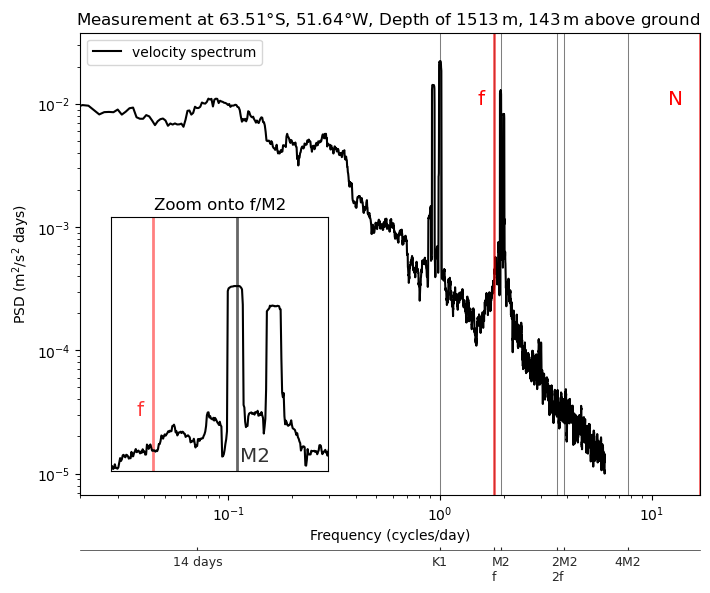

In [33]:
# Put everything together in a complicated figure

fig, ax = plt.subplots(1, figsize = (8,6))
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fill_label_flag = False

ax.loglog(freq,kinetic_psd, c = "k", label = "velocity spectrum")

# Create an inset figure
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
axins = ax.inset_axes(bounds = [0.05,0.05,0.35,0.55]) # ]width="35%", height="55%", loc=3, borderpad=2)
axins.vlines(
    coriolis_frequency_in_cpd,
    1e-6,
    1e1,
    color="r",
    alpha=0.5,
    linestyle="-",
    linewidth=2,
)
axins.text(1.77, 0.7 * 1e-3, "f", color="r", alpha=0.8, size = "x-large")
axins.vlines(
    24 / 12.4, 1e-6, 1e-1, color="k", alpha=0.6, linestyle="-", linewidth=2
)
axins.text(1.94, 0.25 * 1e-3, "M2", color="k", alpha=0.8, size = "x-large")

# Turn ticklabels of insets off
axins.tick_params(
    axis="both",
    which="both",
    labelleft=False,
    labelbottom=False,
    left=False,
    bottom=False,
)

axins.loglog(freq,kinetic_psd, c = "k")
axins.set_xbound(1.73, 2.1)
axins.set_ybound(2e-4, 0.06)
axins.set_title(r"Zoom onto f/M2")
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


ylims = ax.get_ylim()
ax.set_ylim(ylims)

ax2 = helper.Plot.add_tidal_and_f_ticks(ax, coriolis_frequency_in_cpd, upper_bound = 1e1)
ax.vlines(
    avrg_N_in_cpd, 1e-6, 1e-1, color="r", alpha=0.6, linestyle="-", linewidth=2
)
ax.text(12, 1e-2, "N", color="r", alpha=1, size = "x-large")

ax.vlines(
    coriolis_frequency_in_cpd, 1e-6, 1e-1, color="r", alpha=0.6, linestyle="-", linewidth=2
)
ax.text(1.5, 1e-2, "f", color="r", alpha=1, size = "x-large")


ax.legend(loc = "upper left")
ax.set_title(f"Measurement at {mooring.location.pretty_print()}, Depth of {measurement_depth}$\,$m, {mab_of_measurement}$\,$m above ground", loc = "right")

ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("PSD (m$^2$/s$^2$ days)")
ax.set_xlim(2e-2,17);

#connection lines
#y0 = ax.get_ylim()[0]
#ax.plot([coriolis_frequency_in_cpd, 0.039], [y0+0.5e-6,1.65e-5], "k--", lw = 0.5) #f
#ax.plot([24 / 12.4, 0.081], [y0+1.5e-6,1.65e-5],"k--", lw =0.5) #M2       

This looks nice, but is not so useful at the moment, as this is only the spectrum of the horizontal kinetic energy. But for mixing, we are interested in the total energy, including the potential and vertical kinetic energy. 

# Spectral Relations

For this this point,we take the GM spectrum as an example. At no point in time are the values used in the analis, but it allows nicer visualizations. 

In [34]:
import src.gm_library as gm

In [35]:
def calculate_GM_spectrum(f,N,N0,b):
    """
    Here happens the actual calculation of the GM81 spectrum.
    GM equations are copied from https://github.com/joernc/GM81 
    under the GNU General Public License.
    """
    # This module implements the empirical spectrum of internal waves developed by
    # Garrett and Munk, in the incarnation presented in Munk's chapter in Evolution
    # of Physical Oceanography, which can be downloaded here:
    # http://ocw.mit.edu/resources/res-12-000-evolution-of-physical-oceanography-spring-2007/part-2/wunsch_chapter9.pdf
    # The variable names follow Munk's notation.

    # frequency
    omg = np.logspace(np.log10(1.01*f), np.log10(N), 401) #Where does the 401 come from?

    # horizontal wavenumber
    k = 2*np.pi*np.logspace(-6, -2, 401)

    # mode number
    j = np.arange(1, 100)

    # reshape to allow multiplication into 2D array
    Omg = np.reshape(omg, (omg.size,1))
    K = np.reshape(k, (k.size,1))
    J = np.reshape(j, (1,j.size))

    # frequency spectra (KE and PE)
    K_omg_j = gm.K_omg_j(Omg, J, f, N, N0, b)
    P_omg_j = gm.P_omg_j(Omg, J, f, N, N0, b)

    # wavenumber spectra (KE and PE)
    K_k_j = gm.K_k_j(K, J, f, N, N0, b)
    P_k_j = gm.P_k_j(K, J, f, N, N0, b)

    # sum over modes (j refers to modes)
    K_omg = np.sum(K_omg_j, axis=1)
    P_omg = np.sum(P_omg_j, axis=1)
    K_k = np.sum(K_k_j, axis=1)
    P_k = np.sum(P_k_j, axis=1)

    return omg, K_omg, P_omg

#### Original GM values

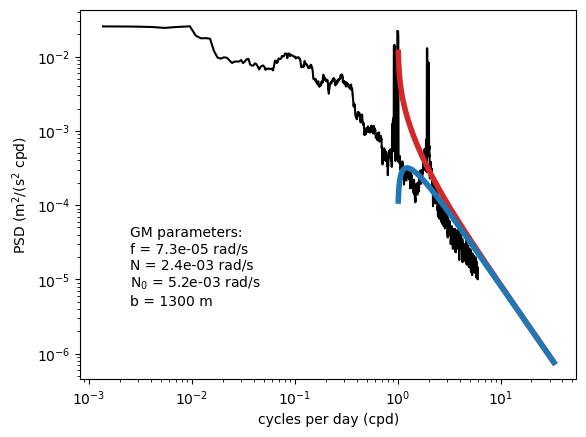

In [36]:
# Coriolis frequency
f = 7.3e-5

# buoyancy frequency (corresponding to 1000 m depth)
N = 2.4e-3

# surface-extrapolated buoyancy frequency
N0 = 5.2e-3

# e-folding scale of N(z)
b = 1.3e3

fig,ax = plt.subplots(1)
ax.loglog(freq,kinetic_psd,"k")
omega, K_omg, P_omg = calculate_GM_spectrum(f,N,N0,b)
ax.loglog(24*3600*omega/(2*np.pi), 2*np.pi*K_omg/3600/24, label='KE', zorder = 5, lw = 4, color = "tab:red")
ax.loglog(24*3600*omega/(2*np.pi), 2*np.pi*P_omg/3600/24, label='PE', zorder = 5, lw= 4, color = "tab:blue")
#plot GM spectrum       
#a.axvline(corfreq(lat)/2/np.pi,linestyle="--", color="tab:red", alpha = 0.5, zorder = -1)

ax.set_ylabel('PSD (m$^2$/(s$^2$ cpd)')
ax.set_xlabel('cycles per day (cpd)')
ax.text(0.1,0.2, f"GM parameters:\nf = {f:.1e} rad/s\nN = {N:.1e} rad/s\nN$_0$ = {N0:.1e} rad/s\nb = {b:.0f} m",transform = ax.transAxes);

The original GM value are not applicable at all, foremost due to assuming a different latitude

#### Local values

f=1.3e-04
N=1.2e-03


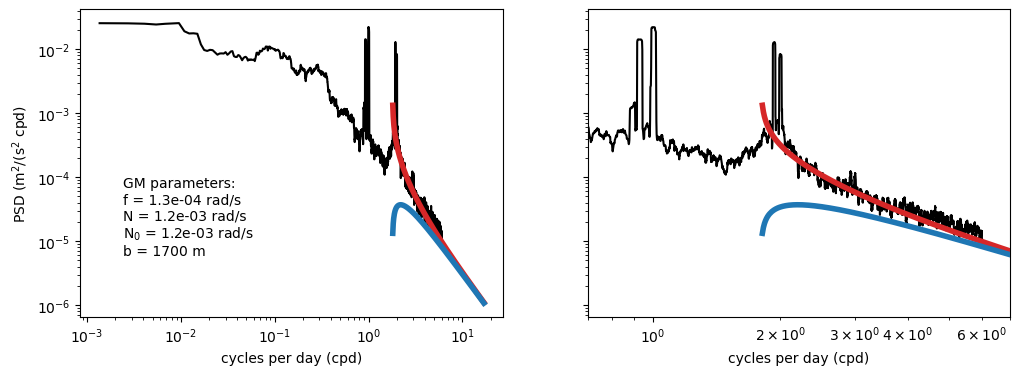

In [37]:
# Coriolis frequency in rad/s
f = helper.Constants.get_coriolis_frequency(
    mooring.location.lat, unit="rad/s", absolute=True
)
print(f"{f=:.1e}") #1.31e-4

# buoyancy frequency in rad/s
N = avrg_N_in_rads #5.06e-4
print(f"{N=:.1e}")

# surface-extrapolated buoyancy frequency
N0 = N #5.06e-4

# e-folding scale of N(z)
b = 1.7e3

fig,ax = plt.subplots(ncols = 2, sharey = True, figsize = (12,4))
ax[0].loglog(freq,kinetic_psd,"k")
omega, K_omg, P_omg = calculate_GM_spectrum(f,N,N0,b)
ax[0].loglog(24*3600*omega/(2*np.pi), 2*np.pi*K_omg/3600/24, label='KE', zorder = 5, lw = 4, color = "tab:red")
ax[0].loglog(24*3600*omega/(2*np.pi), 2*np.pi*P_omg/3600/24, label='PE', zorder = 5, lw= 4, color = "tab:blue")
#plot GM spectrum       
#a.axvline(corfreq(lat)/2/np.pi,linestyle="--", color="tab:red", alpha = 0.5, zorder = -1)

ax[0].set_ylabel('PSD (m$^2$/(s$^2$ cpd)')
ax[0].set_xlabel('cycles per day (cpd)')
ax[0].text(0.1,0.2, f"GM parameters:\nf = {f:.1e} rad/s\nN = {N:.1e} rad/s\nN$_0$ = {N0:.1e} rad/s\nb = {b:.0f} m",transform = ax[0].transAxes);

ax[1].loglog(freq,kinetic_psd,"k")
omega, K_omg, P_omg = calculate_GM_spectrum(f,N,N0,b)
ax[1].loglog(24*3600*omega/(2*np.pi), 2*np.pi*K_omg/3600/24, label='KE', zorder = 5, lw = 4, color = "tab:red")
ax[1].loglog(24*3600*omega/(2*np.pi), 2*np.pi*P_omg/3600/24, label='PE', zorder = 5, lw= 4, color = "tab:blue")
#plot GM spectrum       
#a.axvline(corfreq(lat)/2/np.pi,linestyle="--", color="tab:red", alpha = 0.5, zorder = -1)

ax[1].set_xlabel('cycles per day (cpd)')
#ax[1].text(0.04,0.1, f"GM parameters:\nf = {f:.1e} rad/s\nN = {N:.1e} rad/s\nN$_0$ = {N0:.1e} rad/s\nb = {b:.0f} m",transform = a.transAxes)
ax[1].set_xlim(0.7,7);



## Energy Conversion $E_\text{kin} \rightarrow E_\text{tot}$

From Friederike Pollmanns thesis, section 5.2 we know

\begin{equation} 
\mathcal{E} = 2 \cdot \frac{N² - f²}{N² - \omega²}\frac{\omega²}{\omega² + f²} \mathcal{U}
\end{equation}

In [38]:
def kinetic_to_total_energy(f, N, omega):
    conversion = (
        2*(N**2 - f**2)
        / (N**2 - omega**2)
        * (omega**2)
        / (omega**2 + f**2)
    )
    return conversion

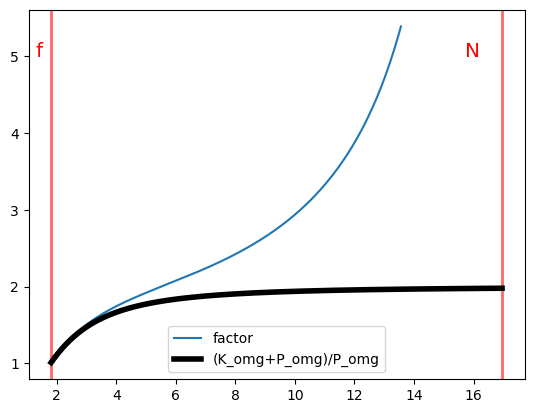

In [39]:
factor = kinetic_to_total_energy(f, N, omega)
E_omg = factor * K_omg
plt.plot(24*3600*omega[:-40]/(2*np.pi),factor[:-40], label = "factor")
plt.plot(24*3600*omega/(2*np.pi), (K_omg+P_omg)/K_omg, zorder = 5, lw = 4, color = "k", label = "(K_omg+P_omg)/P_omg")
plt.axvline(avrg_N_in_cpd, color="r", alpha=0.6, linestyle="-", linewidth=2)
plt.text(15.7, 5, "N", color="r", alpha=1, size = "x-large")
plt.axvline(coriolis_frequency_in_cpd, color="r", alpha=0.6, linestyle="-", linewidth=2)
plt.text(1.3, 5, "f", color="r", alpha=1, size = "x-large")
plt.legend()

So it works, but only close to $f$ far away from $N$.

Text(0.5, 0, 'cycles per day (cpd)')

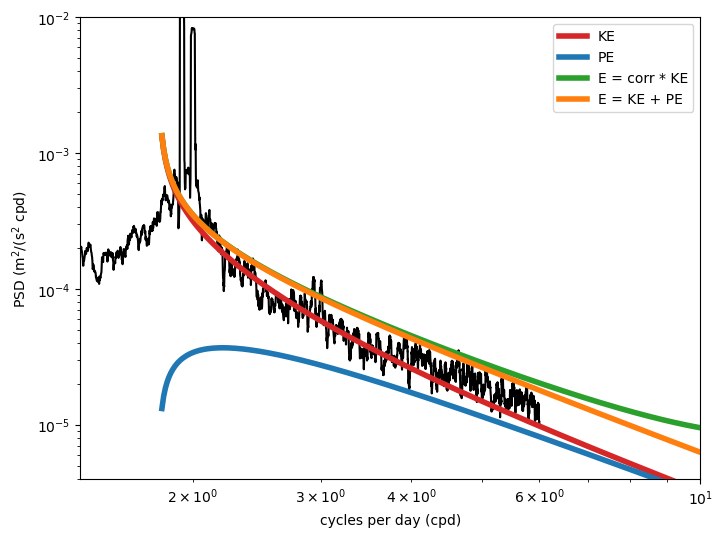

In [40]:
fig,ax = plt.subplots(1, figsize = (8,6))
ax.loglog(freq,kinetic_psd,"k")
omega, K_omg, P_omg = calculate_GM_spectrum(f,N,N0,b)
ax.loglog(24*3600*omega/(2*np.pi), 2*np.pi*K_omg/3600/24, label='KE', zorder = 5, lw = 4, color = "tab:red")
ax.loglog(24*3600*omega/(2*np.pi), 2*np.pi*P_omg/3600/24, label='PE', zorder = 5, lw= 4, color = "tab:blue")
ax.loglog(24*3600*omega[:-1]/(2*np.pi), 2*np.pi*E_omg[:-1]/3600/24, zorder = 5, lw= 4, color = "tab:green", label = "E = corr * KE")
ax.loglog(24*3600*omega/(2*np.pi), 2*np.pi*(K_omg+P_omg)/3600/24, zorder = 5, lw= 4, color = "tab:orange", label = "E = KE + PE")
#plot GM spectrum       
#a.axvline(corfreq(lat)/2/np.pi,linestyle="--", color="tab:red", alpha = 0.5, zorder = -1)
ax.set_xlim(1.4,10)
ax.set_ylim(4e-6,1e-2)
ax.legend()
ax.set_ylabel('PSD (m$^2$/(s$^2$ cpd)')
ax.set_xlabel('cycles per day (cpd)')
#ax.text(0.1,0.2, f"GM parameters:\nf = {f:.1e} rad/s\nN = {N:.1e} rad/s\nN$_0$ = {N0:.1e} rad/s\nb = {b:.0f} m",transform = ax.transAxes);

In [41]:
fN_freq, fN_kinetic_psd = helper.Constants.cut_to_f_N_interval(
    freq,
    kinetic_psd, 
    f = coriolis_frequency_in_cpd,
    N = avrg_N_in_cpd
)
factor = kinetic_to_total_energy(
    f = coriolis_frequency_in_cpd,
    N = avrg_N_in_cpd,
    omega = fN_freq
)
assert np.all(factor>=0.999)
total_psd = factor*fN_kinetic_psd

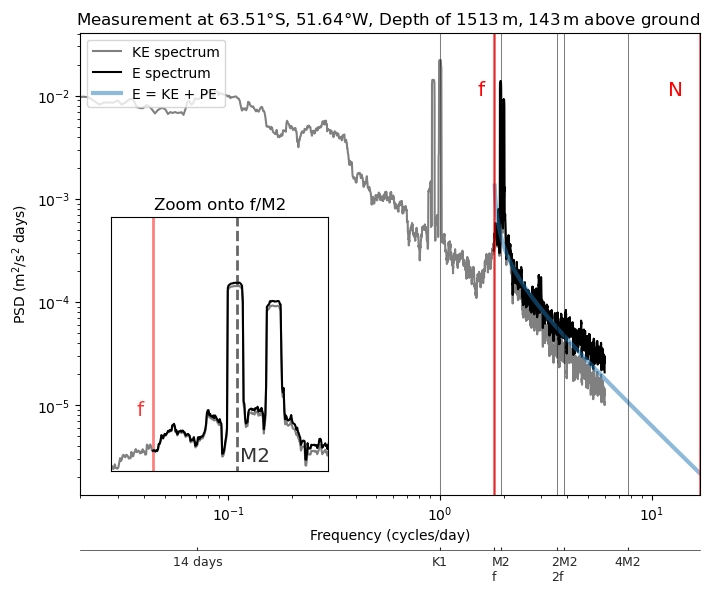

In [43]:
# Put everything together in a complicated figure

fig, ax = plt.subplots(1, figsize = (8,6))
fill_label_flag = False

ax.loglog(freq,kinetic_psd, c = "gray", label = "KE spectrum")
ax.loglog(fN_freq,total_psd, c = "k", label = "E spectrum")
ax.loglog(24*3600*omega/(2*np.pi), 2*np.pi*(K_omg+P_omg)/3600/24, lw = 3, color = "tab:blue", alpha = 0.5, label = "E = KE + PE")

# Create an inset figure
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
axins = ax.inset_axes(bounds = [0.05,0.05,0.35,0.55])
axins.vlines(
    coriolis_frequency_in_cpd,
    1e-6,
    1e1,
    color="r",
    alpha=0.5,
    linestyle="-",
    linewidth=2,
)
axins.text(1.77, 0.7 * 1e-3, "f", color="r", alpha=0.8, size = "x-large")
axins.vlines(
    24 / 12.4, 1e-6, 1e-1, color="k", alpha=0.6, linestyle="--", linewidth=2
)
axins.text(1.94, 0.25 * 1e-3, "M2", color="k", alpha=0.8, size = "x-large")

# Turn ticklabels of insets off
axins.tick_params(
    axis="both",
    which="both",
    labelleft=False,
    labelbottom=False,
    left=False,
    bottom=False,
)

axins.loglog(freq,kinetic_psd, c = "gray", label = "KE spectrum")
axins.loglog(fN_freq,total_psd, c = "k", label = "E spectrum")

axins.set_xbound(1.73, 2.1)
axins.set_ybound(2e-4, 0.06)
axins.set_title(r"Zoom onto f/M2")
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


ylims = ax.get_ylim()
ax.set_ylim(ylims)

ax2 = helper.Plot.add_tidal_and_f_ticks(ax, coriolis_frequency_in_cpd, upper_bound = 1e1)
ax.vlines(
    avrg_N_in_cpd, 1e-6, 1e-1, color="r", alpha=0.6, linestyle="-", linewidth=2
)
ax.text(12, 1e-2, "N", color="r", alpha=1, size = "x-large")

ax.vlines(
    coriolis_frequency_in_cpd, 1e-6, 1e-1, color="r", alpha=0.6, linestyle="-", linewidth=2
)
ax.text(1.5, 1e-2, "f", color="r", alpha=1, size = "x-large")


ax.legend(loc = "upper left")
ax.set_title(f"Measurement at {mooring.location.pretty_print()}, Depth of {measurement_depth}$\,$m, {mab_of_measurement}$\,$m above ground", loc = "right")

ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("PSD (m$^2$/s$^2$ days)")
ax.set_xlim(2e-2,17);

#connection lines
#y0 = ax.get_ylim()[0]
#ax.plot([coriolis_frequency_in_cpd, 0.039], [y0+0.5e-6,1.65e-5], "k--", lw = 0.5) #f
#ax.plot([24 / 12.4, 0.081], [y0+1.5e-6,1.65e-5],"k--", lw =0.5) #M2       

### Extension up to $N$

We extend the spectra up to $N$ with $A\omega^{s}$, with a constant spectral slope $s<0$. For comparison, the GM model assumes a spectral slope of $-2$.

Because the conversion factor is not constant close to $N$, we fit the slope to the unaltered horizontal kinetic energy spectrum and "glue" it then to total energy spectrum, which from theory should have the same spectral slope. 

In [44]:
last_freq = fN_freq[-1]
last_value = np.mean(total_psd[-50:])
extent_freq = np.linspace(last_freq, avrg_N_in_cpd, 20)

In [45]:
def extension(omega, A, s = -2):
    return A*omega**s

In [46]:
start_freq = 3.2 #cpd
start_index = np.argmin(np.abs(fN_freq-start_freq))         

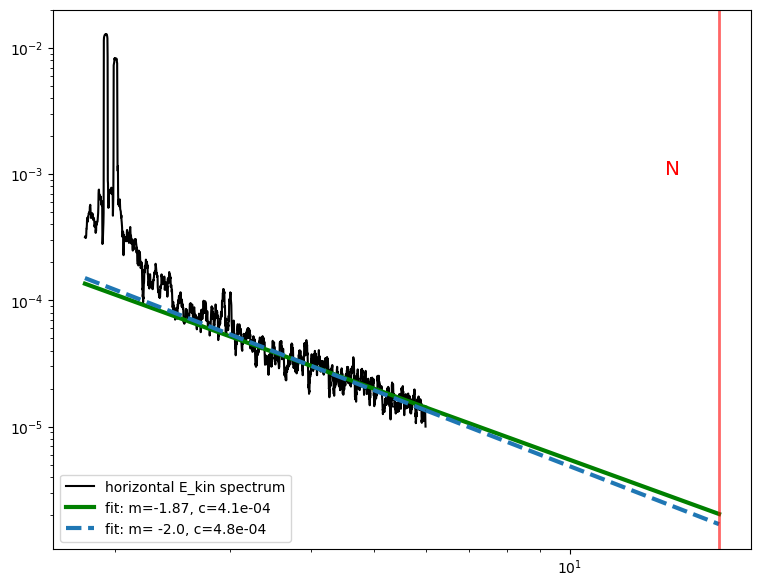

In [47]:
fig,ax = plt.subplots(1, figsize = (9,7))
x = fN_freq[start_index:]
y = fN_kinetic_psd[start_index:]
from scipy.optimize import curve_fit
def func_powerlaw(x, m, c):
    return x**m * c
popt, pcov  = curve_fit(func_powerlaw, x, y, p0 = np.asarray([-2,1e4]))
slope = tuple(popt)[0]
slope_error = np.sqrt(np.diag(pcov))[0]
ax.loglog(fN_freq,fN_kinetic_psd, c = "k", label = "horizontal E_kin spectrum")
ax.plot(fN_freq, func_powerlaw(fN_freq, *popt), 'g-', lw = 3)
ax.plot(extent_freq, func_powerlaw(extent_freq, *popt), 'g-', lw = 3, label='fit: m=%5.2f, c=%5.1e' % tuple(popt))

def GM_func(x, c):
    return x**-2 * c
gm_popt, gm_pcov  = curve_fit(GM_func, x, y, p0 = 1e4)
ax.plot(fN_freq, GM_func(fN_freq, gm_popt), c = "tab:blue", ls = '--', lw = 3)
ax.plot(extent_freq, GM_func(extent_freq,gm_popt), c = "tab:blue", ls ='--', lw = 3, label='fit: m= -2.0, c=%5.1e' % gm_popt)
ax.axvline(
    avrg_N_in_cpd, color="r", alpha=0.6, linestyle="-", linewidth=2
)
ax.text(14, 1e-3, "N", color="r", alpha=1, size = "x-large")
ax.legend();

In [48]:
integral_f_wmax = integrate_psd_interval(fN_freq, fN_kinetic_psd)
print(f"Measured E_kin:\tIntegral f - w_max = {integral_f_wmax :.1e}")
integral_wmax_N = integrate_psd_interval(extent_freq, func_powerlaw(extent_freq, *popt))
print(
    f"fitted slope:\tIntegral w_max - N = {integral_wmax_N:.1e}, Ratio to E_kin= {(integral_wmax_N)/(integral_f_wmax):.1%}"
)
gm_integral_wmax_N = integrate_psd_interval(extent_freq, GM_func(extent_freq, gm_popt))
print(
    f"GM slope:\tIntegral w_max - N = {gm_integral_wmax_N:.1e}, Ratio to E_kin = {(gm_integral_wmax_N)/(integral_f_wmax):.1%}"
)


Measured E_kin:	Integral f - w_max = 8.6e-04
fitted slope:	Integral w_max - N = 5.7e-05, Ratio to E_kin= 6.6%
GM slope:	Integral w_max - N = 5.1e-05, Ratio to E_kin = 6.0%


In [50]:
#fit slope height for the total kinetic spectrum, given the calculated slope of the kinetic energy spectrum
x = fN_freq[start_index:]
y = total_psd[start_index:]
def func_powerlaw_total_psd(x, c):
    return x**slope * c
slope_height, _pcov  = curve_fit(func_powerlaw_total_psd, x, y, p0 = np.asarray([1e4]))

In [51]:
integral_f_wmax = integrate_psd_interval(fN_freq, total_psd)
print(f"Measured E_kin:\tIntegral f - w_max = {integral_f_wmax :.1e}")
integral_wmax_N = integrate_psd_interval(extent_freq, func_powerlaw_total_psd(extent_freq, slope_height))
print(
    f"fitted slope:\tIntegral w_max - N = {integral_wmax_N:.1e}, Ratio to total E= {(integral_wmax_N)/(integral_f_wmax):.1%}"
)

Measured E_kin:	Integral f - w_max = 1.0e-03
fitted slope:	Integral w_max - N = 1.0e-04, Ratio to total E= 9.8%


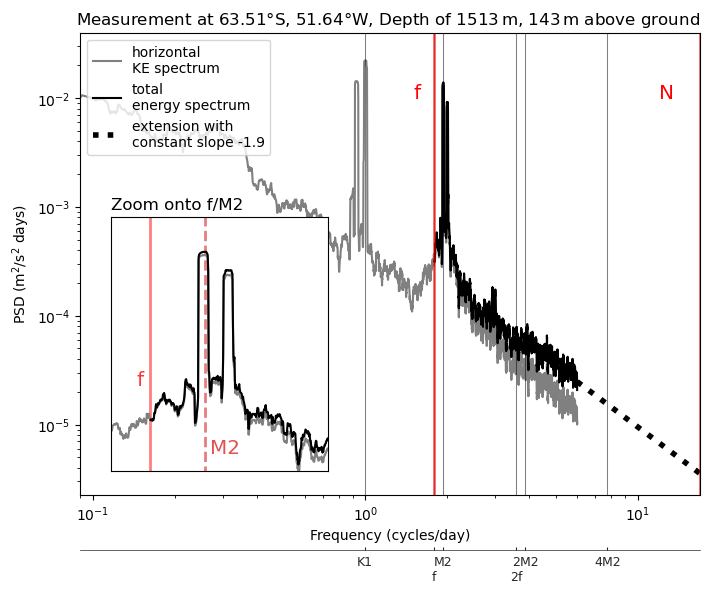

In [54]:
# Put everything together in a complicated figure

fig, ax = plt.subplots(1, figsize = (8,6))
fill_label_flag = False

#ax.loglog(24*3600*omega/(2*np.pi), 2*np.pi*(K_omg+P_omg)/3600/24, lw = 3, color = "tab:blue", alpha = 0.5, label = "E = KE + PE")
ax.loglog(freq,kinetic_psd, c = "gray", label = "horizontal\nKE spectrum")
ax.loglog(fN_freq,total_psd, c = "k", label = "total\nenergy spectrum")

ax.plot(extent_freq, func_powerlaw_total_psd(extent_freq,slope_height), c = "k", ls =':', lw = 4, label = f"extension with\nconstant slope {slope:1.1f}")

# Create an inset figure
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
axins = ax.inset_axes(bounds = [0.05,0.05,0.35,0.55])
axins.vlines(
    coriolis_frequency_in_cpd,
    1e-6,
    1e1,
    color="r",
    alpha=0.5,
    linestyle="-",
    linewidth=2,
)
axins.text(1.76, 0.7 * 1e-3, "f", color="r", alpha=0.8, size = "x-large")
axins.vlines(
    24 / 12.4, 1e-6, 1e-1, color="tab:red", alpha=0.6, linestyle="--", linewidth=2
)
axins.text(1.95, 0.15 * 1e-3, "M2", color="tab:red", alpha=0.8, size = "x-large")

# Turn ticklabels of insets off
axins.tick_params(
    axis="both",
    which="both",
    labelleft=False,
    labelbottom=False,
    left=False,
    bottom=False,
)

axins.loglog(freq,kinetic_psd, c = "gray", label = "horizontal\nKE spectrum")
axins.loglog(fN_freq,total_psd, c = "k", label = "total\nenergy spectrum")


axins.set_xbound(1.7, 2.3)
axins.set_ybound(1e-4, 0.03)
axins.set_title(r"Zoom onto f/M2", loc = "left")
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


ylims = ax.get_ylim()
ax.set_ylim(ylims)

ax2 = helper.Plot.add_tidal_and_f_ticks(ax, coriolis_frequency_in_cpd, upper_bound = 1e1)
ax.vlines(
    avrg_N_in_cpd, 1e-6, 1e-1, color="r", alpha=0.6, linestyle="-", linewidth=2
)
ax.text(12, 1e-2, "N", color="r", alpha=1, size = "x-large")

ax.vlines(
    coriolis_frequency_in_cpd, 1e-6, 1e-1, color="r", alpha=0.6, linestyle="-", linewidth=2
)
ax.text(1.5, 1e-2, "f", color="r", alpha=1, size = "x-large")


ax.legend(loc = "upper left")
ax.set_title(f"Measurement at {mooring.location.pretty_print()}, Depth of {measurement_depth}$\,$m, {mab_of_measurement}$\,$m above ground", loc = "right")

ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("PSD (m$^2$/s$^2$ days)")
ax.set_xlim(9e-2,17);
#ax.set_xlim(5e-1,17)

#fig.savefig("./figures/Spectrum_Poster", dpi = 300)

#connection lines
#y0 = ax.get_ylim()[0]
#ax.plot([coriolis_frequency_in_cpd, 0.039], [y0+0.5e-6,1.65e-5], "k--", lw = 0.5) #f
#ax.plot([24 / 12.4, 0.081], [y0+1.5e-6,1.65e-5],"k--", lw =0.5) #M2       

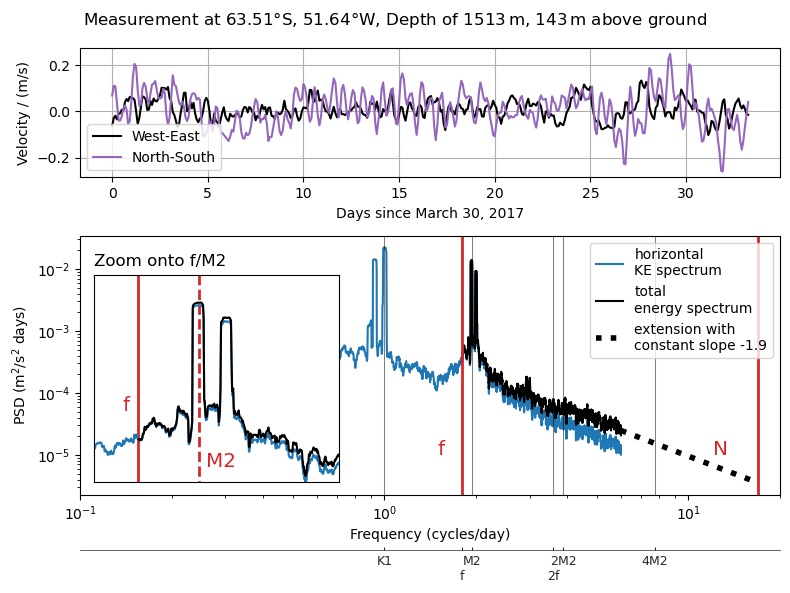

In [80]:
# Put everything together in a complicated figure

#fig, ax = plt.subplots(nrows = 2, figsize=(TWO_COLUMN_WIDTH*cm, 0.8*TWO_COLUMN_WIDTH*cm), height_ratios = (1,2))
fig, ax = plt.subplots(2, figsize = (8,6), height_ratios = (1,2))


cv = mooring[str(1513)].to_numpy()
time = mooring["time"].to_numpy()

#print(np.shape(cv))
time = time[750:1150]
cv = cv[750:1150]

def get_days_between(datePast, dateFuture):
    difference = dateFuture - datePast
    return difference.astype('timedelta64[s]').astype(np.int32) / datetime.timedelta(days=1).total_seconds()

days = [get_days_between(time[0], t) for t in time]

ax[0].grid()
ax[0].plot(days, np.real(cv),"k", label = 'West-East')
ax[0].plot(days, np.imag(cv),"tab:purple", label = 'North-South')
ax[0].legend()

ax[0].set_xlabel(f"Days since {pd.to_datetime(time[0]).strftime('%B %d, %Y')}")
#axis[1].set_ylabel("$v$ velocity / (m/s)")

#plt.xlabel("common X")
ax[0].set_ylabel('Velocity / (m/s)')

fill_label_flag = False

#ax.loglog(24*3600*omega/(2*np.pi), 2*np.pi*(K_omg+P_omg)/3600/24, lw = 3, color = "tab:blue", alpha = 0.5, label = "E = KE + PE")
ax[1].loglog(freq[-4000:],kinetic_psd[-4000:], c = "tab:blue", label = "horizontal\nKE spectrum")
ax[1].loglog(fN_freq,total_psd, c = "k", label = "total\nenergy spectrum")

ax[1].plot(extent_freq, func_powerlaw_total_psd(extent_freq,slope_height), c = "k", ls =':', lw = 4, label = f"extension with\nconstant slope {slope:1.1f}")

# Create an inset figure
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
axins = ax[1].inset_axes(bounds = [0.02,0.05,0.35,0.8])
axins.vlines(
    coriolis_frequency_in_cpd,
    1e-6,
    1e1,
    color="tab:red",
    alpha=1,
    linestyle="-",
    linewidth=2,
)
axins.text(1.76, 0.7 * 1e-3, "f", color="tab:red", alpha=1, size = "x-large")
axins.vlines(
    24 / 12.4, 1e-6, 1e-1, color="tab:red", alpha=1, linestyle="--", linewidth=2
)
axins.text(1.95, 0.15 * 1e-3, "M2", color="tab:red", alpha=1, size = "x-large")

# Turn ticklabels of insets off
axins.tick_params(
    axis="both",
    which="both",
    labelleft=False,
    labelbottom=False,
    left=False,
    bottom=False,
)

axins.loglog(freq,kinetic_psd, c = "tab:blue", label = "horizontal\nKE spectrum")
axins.loglog(fN_freq,total_psd, c = "k", label = "total\nenergy spectrum")


axins.set_xbound(1.7, 2.3)
axins.set_ybound(1e-4, 0.03)
axins.set_title(r"Zoom onto f/M2", loc = "left")
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


ylims = ax[1].get_ylim()
ax[1].set_ylim(ylims)

ax2 = helper.Plot.add_tidal_and_f_ticks(ax[1], coriolis_frequency_in_cpd, upper_bound = 1e1)
ax[1].vlines(
    avrg_N_in_cpd, 1e-6, 1e-1, color="tab:red", alpha=1, linestyle="-", linewidth=2
)
ax[1].text(12, 1e-5, "N", color="tab:red", alpha=1, size = "x-large")

ax[1].vlines(
    coriolis_frequency_in_cpd, 1e-6, 1e-1, color="tab:red", alpha=1, linestyle="-", linewidth=2
)
ax[1].text(1.5, 1e-5, "f", color="tab:red", alpha=1, size = "x-large")


ax[1].legend(loc = "upper right")
fig.suptitle(f"Measurement at {mooring.location.pretty_print()}, Depth of {measurement_depth}$\,$m, {mab_of_measurement}$\,$m above ground")

ax[1].set_xlabel("Frequency (cycles/day)")
ax[1].set_ylabel("PSD (m$^2$/s$^2$ days)")
ax[1].set_xlim(1e-1,20);
#ax.set_xlim(5e-1,17)


""""""
#connection lines
#y0 = ax.get_ylim()[0]
#ax.plot([coriolis_frequency_in_cpd, 0.039], [y0+0.5e-6,1.65e-5], "k--", lw = 0.5) #f
#ax.plot([24 / 12.4, 0.081], [y0+1.5e-6,1.65e-5],"k--", lw =0.5) #M2       



fig.tight_layout()

fig.savefig("./TimeSeries_plus_Spectrum.png", dpi = 400, bbox_inches='tight')

slope = -1.9, slope_error = 2.2e-02, rel. Errror = 1.2%
Min slope Integral = 9.8e-05
Max slope Integral = 1.0e-04
Diff = 3.7e-06, Ratio to f_wmax integral= 0.4%


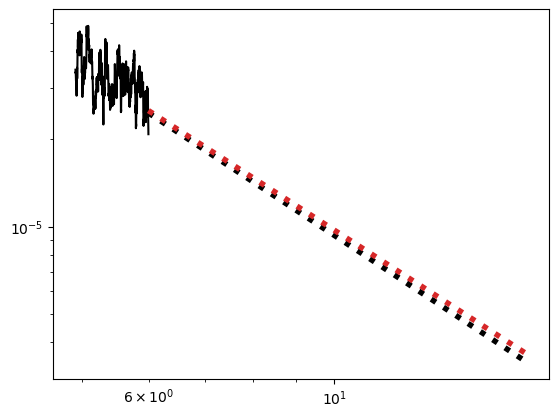

In [81]:
print(f"{slope = :.1f}, {slope_error = :.1e}, rel. Errror = {slope_error/abs(slope):.1%}")

fig, ax = plt.subplots(1)

ax.loglog(fN_freq[-800:],total_psd[-800:], c = "k", label = "total\nenergy spectrum")

x = fN_freq[start_index:]
y = total_psd[start_index:]
def func_powerlaw_total_psd(x, c):
    return x**(slope-slope_error) * c
popt, pcov  = curve_fit(func_powerlaw_total_psd, x, y, p0 = np.asarray([1e4]))
ax.loglog(extent_freq, func_powerlaw_total_psd(extent_freq,popt), c = "k", ls =':', lw = 4)#, label = f"extension with\nconstant slope {(slope-perr):1.1f}")
integral_min_slope = integrate_psd_interval(extent_freq, func_powerlaw_total_psd(extent_freq, popt))
print(
    f"Min slope Integral = {integral_min_slope:.1e}"
)

def func_powerlaw_total_psd(x, c):
    return x**(slope+slope_error) * c
popt, pcov  = curve_fit(func_powerlaw_total_psd, x, y, p0 = np.asarray([1e4]))
ax.loglog(extent_freq, func_powerlaw_total_psd(extent_freq,popt), c = "tab:red", ls =':', lw = 4)#, label = f"extension with\nconstant slope {(slope+perr):1.1f}")
integral_max_slope = integrate_psd_interval(extent_freq, func_powerlaw_total_psd(extent_freq, popt))
print(
    f"Max slope Integral = {integral_max_slope:.1e}"
)
diff = np.abs(integral_max_slope - integral_min_slope)
print(
    f"Diff = {diff:.1e}, Ratio to f_wmax integral= {diff/integral_f_wmax:.1%}"
)

#### Look at the spectral slopes of all spectra

In [82]:
import re 
def sorted_nicely( l ): 
    """ 
    Sort the given iterable in the way that humans expect.
    https://stackoverflow.com/questions/2669059/how-to-sort-alpha-numeric-set-in-python
    """ 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

(-63.40,-52.29), 299m: N = 19.4 cpd, slope = -1.92
(-63.40,-52.29), 505m: N = 16.6 cpd, slope = -2.00
(-63.40,-52.29), 614m: N = 9.3 cpd, slope = -2.27
(-63.51,-51.64), 1318m: N = 15.6 cpd, slope = -2.25
(-63.51,-51.64), 1513m: N = 17.0 cpd, slope = -1.87
(-63.51,-51.64), 1625m: N = 10.8 cpd, slope = -2.00
(-63.66,-50.81), 750m: Couldn't retrieve N value
(-63.66,-50.81), 2143m: N = 15.8 cpd, slope = -1.02
(-63.66,-50.81), 2350m: N = 18.8 cpd, slope = -1.78
(-63.78,-50.09), 2400m: N = 13.4 cpd, slope = -1.51
(-63.78,-50.09), 2615m: N = 20.3 cpd, slope = -1.37
(-63.78,-50.09), 2724m: N = 15.3 cpd, slope = -1.58
(-63.92,-49.27), 3036m: N = 10.5 cpd, slope = -0.87
(-63.92,-49.27), 3299m: N = 22.6 cpd, slope = -1.00
(-63.92,-49.27), 3358m: N = 18.0 cpd, slope = -1.24
(-64.07,-48.38), 3835m: N = 29.0 cpd, slope = -1.75
(-64.22,-47.49), 4120m: N = 19.2 cpd, slope = -2.37
Instrument depth was corrected from -1 to 0 mab.
(-64.22,-47.49), 4160m: N = 13.9 cpd, slope = -2.07


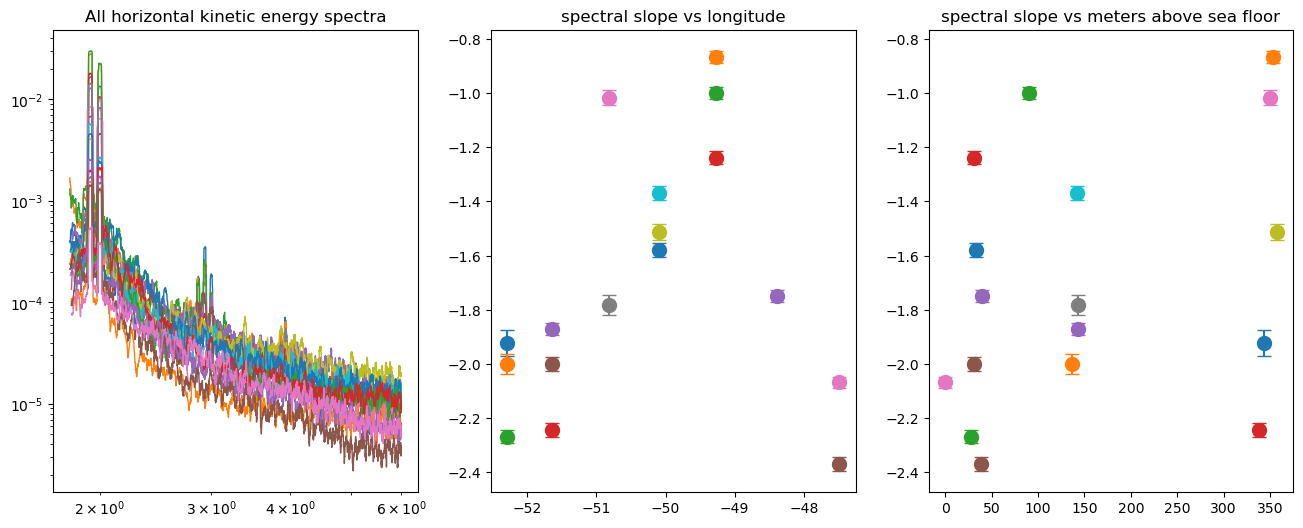

In [85]:
fig, ax = plt.subplots(ncols = 3, figsize = (16,6))

slopes = []
slope_errors = []

for i,mooring in enumerate(list_of_moorings):
    # iterate over all time series/columns in the mooring dataframe
    for measurement_depth in sorted_nicely(mooring.columns):
        if measurement_depth == "time":
            continue
        complex_velocity = mooring[measurement_depth]
        complex_velocity_array = helper.Data.cut_trailing_nans(
            complex_velocity.to_numpy()
        )
        freq, velocity_spectrum = spectra.total_multitaper(
            complex_velocity_array, dt=1 / 12, P=TIME_BANDWIDTH_PRODUCT
        )
        kinetic_psd = velocity_spectrum/2

        
        # get instrument depth in units of meter above the sea floor
        mab_of_measurement = int(max_depth_dict[mooring.location.lon]) - int(measurement_depth) 

        if mab_of_measurement < 0 and mab_of_measurement > -2:
            print(f"Instrument depth was corrected from {mab_of_measurement} to 0 mab.")
            mab_of_measurement = 0

        # get a typical N value, derived from CTD profiles
        column_name = f"({mooring.location.lat:.2f},{mooring.location.lon:.2f})"    

        try:
            avrg_N_in_rads = N_table.loc[
                N_table["mab"] == mab_of_measurement, column_name
            ].item()
        except ValueError:
            print(f"{column_name}, {measurement_depth}m: Couldn't retrieve N value")
            continue
            
        avrg_N_in_cpd = avrg_N_in_rads /(2*np.pi) *86400
        
        # Coriolis frequency in cpd
        coriolis_frequency_in_cpd = helper.Constants.get_coriolis_frequency(
            mooring.location.lat, unit="cpd", absolute=True
        )

        fN_freq, fN_kinetic_psd = helper.Constants.cut_to_f_N_interval(
            freq,
            kinetic_psd, 
            f = coriolis_frequency_in_cpd,
            N = avrg_N_in_cpd
        )
        #factor = kinetic_to_total_energy(
        #    f = coriolis_frequency_in_cpd,
        #    N = avrg_N_in_cpd,
        #    omega = fN_freq
        #)
        #assert np.all(factor>=0.999)
        #total_psd = factor*fN_psd
        #total_psd = fN_kinetic_psd
        
        
        last_freq = fN_freq[-1]
        extent_freq = np.linspace(last_freq, avrg_N_in_cpd, 20)


        # start of the data range, that gets fitted
        start_freq = 3.2 #cpd
        start_index = np.argmin(np.abs(fN_freq-start_freq))         

        x = fN_freq[start_index:]
        y = fN_kinetic_psd[start_index:]

        def func_powerlaw(x, m, c):
            return x**m * c
        popt, pcov  = curve_fit(func_powerlaw, x, y, p0 = np.asarray([-2,1e4]))
        perr = np.sqrt(np.diag(pcov))
        slope = tuple(popt)[0] 
        slopes.append(slope)
        slope_errors.append(perr[0])        
        
        ax[0].set_title("All horizontal kinetic energy spectra")
        ax[0].loglog(fN_freq,fN_kinetic_psd, lw = 1)
        ax[1].set_title("spectral slope vs longitude")
        ax[1].errorbar(mooring.location.lon, tuple(popt)[0], yerr= perr[0], fmt = ".", markersize = 20, capsize = 5)
        ax[2].set_title("spectral slope vs meters above sea floor")
        ax[2].errorbar(mab_of_measurement, tuple(popt)[0], yerr = perr[0], fmt = ".", markersize = 20, capsize = 5)
        #ax.plot(fN_freq, func_powerlaw(fN_freq, *popt), 'g-', lw = 3)
        #ax.plot(extent_freq, func_powerlaw(extent_freq, *popt), 'g-', lw = 3, label='fit: m=%5.2f, c=%5.1e' % tuple(popt))

        print(f"{column_name}, {measurement_depth}m: N = {avrg_N_in_cpd:.1f} cpd, slope = {slope:.2f}")


(-63.40,-52.29), 299m: N = 19.4 cpd, slope = -1.92, ax_index = 0
(-63.40,-52.29), 505m: N = 16.6 cpd, slope = -2.00, ax_index = 0
(-63.40,-52.29), 614m: N = 9.3 cpd, slope = -2.27, ax_index = 0
(-63.51,-51.64), 1318m: N = 15.6 cpd, slope = -2.25, ax_index = 0
(-63.51,-51.64), 1513m: N = 17.0 cpd, slope = -1.87, ax_index = 0
(-63.51,-51.64), 1625m: N = 10.8 cpd, slope = -2.00, ax_index = 0
(-63.66,-50.81), 750m: Couldn't retrieve N value
(-63.66,-50.81), 2143m: N = 15.8 cpd, slope = -1.02, ax_index = 1
(-63.66,-50.81), 2350m: N = 18.8 cpd, slope = -1.78, ax_index = 1
(-63.78,-50.09), 2400m: N = 13.4 cpd, slope = -1.51, ax_index = 1
(-63.78,-50.09), 2615m: N = 20.3 cpd, slope = -1.37, ax_index = 1
(-63.78,-50.09), 2724m: N = 15.3 cpd, slope = -1.58, ax_index = 1
(-63.92,-49.27), 3036m: N = 10.5 cpd, slope = -0.87, ax_index = 1
(-63.92,-49.27), 3299m: N = 22.6 cpd, slope = -1.00, ax_index = 1
(-63.92,-49.27), 3358m: N = 18.0 cpd, slope = -1.24, ax_index = 1
(-64.07,-48.38), 3835m: N = 29.

Text(0.5, 1.0, 'Towards Deep Sea')

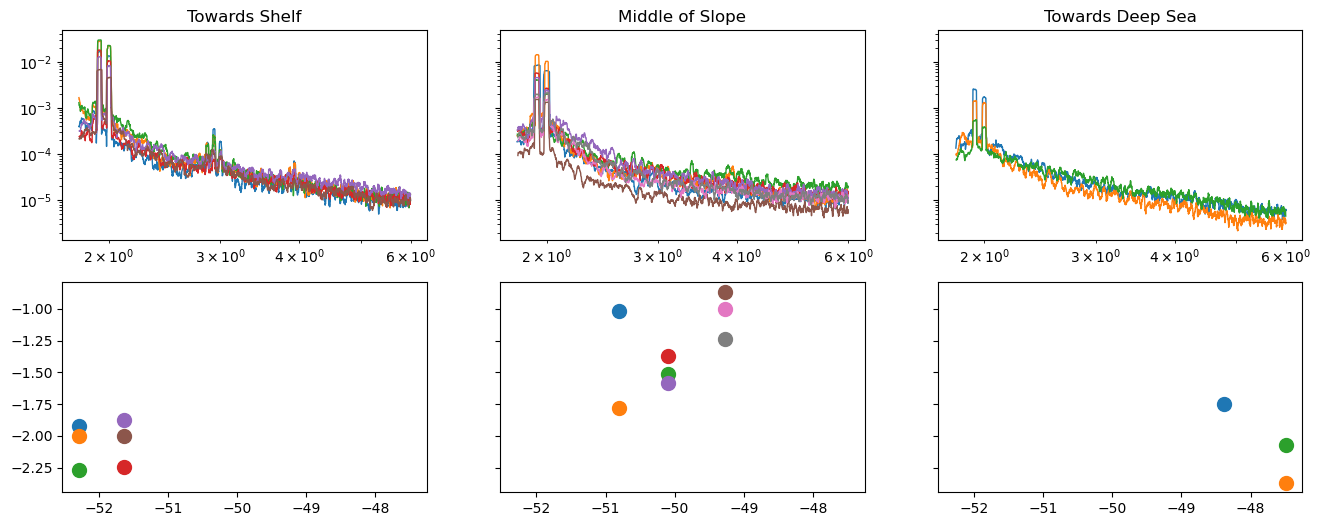

In [86]:
fig, ax = plt.subplots(ncols = 3, nrows = 2, sharey = "row", sharex = "row", figsize = (16,6))

slopes = []
slope_errors = []

for i,mooring in enumerate(list_of_moorings):
    # iterate over all time series/columns in the mooring dataframe
    for measurement_depth in sorted_nicely(mooring.columns):
        if measurement_depth == "time":
            continue
        complex_velocity = mooring[measurement_depth]
        complex_velocity_array = helper.Data.cut_trailing_nans(
            complex_velocity.to_numpy()
        )
        freq, velocity_spectrum = spectra.total_multitaper(
            complex_velocity_array, dt=1 / 12, P=TIME_BANDWIDTH_PRODUCT
        )
        kinetic_psd = velocity_spectrum/2

        
        # get instrument depth in units of meter above the sea floor
        mab_of_measurement = int(max_depth_dict[mooring.location.lon]) - int(measurement_depth) 

        if mab_of_measurement < 0 and mab_of_measurement > -2:
            print(f"Instrument depth was corrected from {mab_of_measurement} to 0 mab.")
            mab_of_measurement = 0

        # get a typical N value, derived from CTD profiles
        column_name = f"({mooring.location.lat:.2f},{mooring.location.lon:.2f})"    

        try:
            avrg_N_in_rads = N_table.loc[
                N_table["mab"] == mab_of_measurement, column_name
            ].item()
        except ValueError:
            print(f"{column_name}, {measurement_depth}m: Couldn't retrieve N value")
            continue
            
        avrg_N_in_cpd = avrg_N_in_rads /(2*np.pi) *86400
        
        # Coriolis frequency in cpd
        coriolis_frequency_in_cpd = helper.Constants.get_coriolis_frequency(
            mooring.location.lat, unit="cpd", absolute=True
        )

        fN_freq, fN_kinetic_psd = helper.Constants.cut_to_f_N_interval(
            freq,
            kinetic_psd, 
            f = coriolis_frequency_in_cpd,
            N = avrg_N_in_cpd
        )
        #factor = kinetic_to_total_energy(
        #    f = coriolis_frequency_in_cpd,
        #    N = avrg_N_in_cpd,
        #    omega = fN_freq
        #)
        #assert np.all(factor>=0.999)
        #total_psd = factor*fN_psd
        #total_psd = fN_kinetic_psd
        
        
        last_freq = fN_freq[-1]
        extent_freq = np.linspace(last_freq, avrg_N_in_cpd, 20)


        # start of the data range, that gets fitted
        start_freq = 3.2 #cpd
        start_index = np.argmin(np.abs(fN_freq-start_freq))         

        x = fN_freq[start_index:]
        y = fN_kinetic_psd[start_index:]

        def func_powerlaw(x, m, c):
            return x**m * c
        popt, pcov  = curve_fit(func_powerlaw, x, y, p0 = np.asarray([-2,1e4]))
        perr = np.sqrt(np.diag(pcov))
        slope = tuple(popt)[0] 
        slopes.append(slope)
        slope_errors.append(perr[0])        
        
        if mooring.location.lon < -51:
            ax_index = 0
        elif mooring.location.lon > -49:    
            ax_index = 2
        else:
            ax_index = 1
        
        ax[0,ax_index].loglog(fN_freq,fN_kinetic_psd, lw = 1)
        ax[1,ax_index].plot(mooring.location.lon,slope, ".", markersize = 20)
        #ax[1].set_title("spectral slope vs longitude")
        #ax[1].errorbar(mooring.location.lon, tuple(popt)[0], yerr= perr[0], ".", markersize = 20, capsize = 5)
        #ax[2].set_title("spectral slope vs meters above sea floor")
        #ax[2].errorbar(mab_of_measurement, tuple(popt)[0], yerr = perr[0], fmt = ".", markersize = 20, capsize = 5)
        #ax.plot(fN_freq, func_powerlaw(fN_freq, *popt), 'g-', lw = 3)
        #ax.plot(extent_freq, func_powerlaw(extent_freq, *popt), 'g-', lw = 3, label='fit: m=%5.2f, c=%5.1e' % tuple(popt))

        print(f"{column_name}, {measurement_depth}m: N = {avrg_N_in_cpd:.1f} cpd, slope = {slope:.2f}, ax_index = {ax_index}")

ax[0,0].set_title("Towards Shelf")
ax[0,1].set_title("Middle of Slope")
ax[0,2].set_title("Towards Deep Sea")

In [87]:
print(f"Mean slope: {np.mean(slopes):1.2f}")
print(f"Std: {np.std(slopes):1.2f}")

Mean slope: -1.70
Std: 0.45


The energy in the extension will be added to the energy calculated from the observed spectrum

In [88]:
count = 0
for i,mooring in enumerate(list_of_moorings):
    # iterate over all time series/columns in the mooring dataframe
    for measurement_depth in sorted_nicely(mooring.columns):
        if measurement_depth == "time":
            continue
        count += 1   
print(count)        

18


In [ ]:
"""
fig, ax = plt.subplots(ncols = 18, figsize = (20,6))

START_FREQ = 3.2 #cpd
slopes = []   

ax_index = 0
for i,mooring in enumerate(list_of_moorings):
    # iterate over all time series/columns in the mooring dataframe
    for measurement_depth in sorted_nicely(mooring.columns):
        if measurement_depth == "time":
            continue
        complex_velocity = mooring[measurement_depth]
        complex_velocity_array = helper.Data.cut_trailing_nans(
            complex_velocity.to_numpy()
        )
        freq, velocity_spectrum = helper.Spectrum.total_multitaper(
            complex_velocity_array, dt=1 / 12, P=TIME_BANDWIDTH_PRODUCT
        )
        kinetic_psd = velocity_spectrum/2

        
        # get instrument depth in units of meter above the sea floor
        mab_of_measurement = int(max_depth_dict[mooring.location.lon]) - int(measurement_depth) 

        if mab_of_measurement < 0 and mab_of_measurement > -2:
            print(f"Instrument depth was corrected from {mab_of_measurement} to 0 mab.")
            mab_of_measurement = 0

        # get a typical N value, derived from CTD profiles
        column_name = f"({mooring.location.lat:.2f},{mooring.location.lon:.2f})"    
        try:
            avrg_N_in_rads = N_table.loc[
                N_table["mab"] == mab_of_measurement, column_name
            ].item()
        except ValueError:
            print(f"{column_name}, {measurement_depth}m, Couldn't retrieve N value")
            continue
            
        avrg_N_in_cpd = avrg_N_in_rads /(2*np.pi) *86400
        #print(f"{avrg_N_in_cpd = :.1f} cpd")



           
        # Coriolis frequency in cpd
        coriolis_frequency_in_cpd = helper.Constants.get_coriolis_frequency(
            mooring.location.lat, unit="cpd", absolute=True
        )


        fN_freq, fN_kinetic_psd = helper.Constants.cut_to_f_N_interval(
            freq,
            kinetic_psd, 
            f = coriolis_frequency_in_cpd,
            N = avrg_N_in_cpd
        )        
        


        extent_freq = np.linspace(last_freq, avrg_N_in_cpd, 20)

        # start of the data range, that gets fitted
        start_index = np.argmin(np.abs(fN_freq-START_FREQ))         

        x = fN_freq[start_index:]
        y = fN_kinetic_psd[start_index:]

        def func_powerlaw(x, m, c):
            return x**m * c
        popt, pcov  = curve_fit(func_powerlaw, x, y, p0 = np.asarray([-2,1e4]))
        slope = tuple(popt)[0]
        slopes.append(slopes)        
        # Correction factor in cpd
        kinetic_to_total_energy_factor = kinetic_to_total_energy(
            f = coriolis_frequency_in_cpd,
            N = avrg_N_in_cpd,
            omega = fN_freq
        )

        assert np.all(kinetic_to_total_energy_factor > 0.999)

        print(f"{column_name}, {measurement_depth}m: N = {avrg_N_in_cpd:.1f} cpd, slope = {slope:.2f}")
        
        
        # Compare to Correction factor in rad/s
        difference = kinetic_to_total_energy_factor - kinetic_to_total_energy(
            f=coriolis_frequency_in_rads, N=avrg_N_in_rads, omega = fN_freq * (2*np.pi) / 86400
        )
        #assert np.all(np.abs(difference) < 1e-10)
        #plt.plot(fN_freq,kinetic_to_total_energy_factor)
        #plt.plot(fN_freq,kinetic_to_total_energy(
        #    f=coriolis_frequency_in_rads, N=avrg_N_in_rads, omega = fN_freq * (2*np.pi) / 86400
        #), ls = "--")
            
            
        # PSD and the frequency is in units of cpd
        total_psd = kinetic_to_total_energy_factor * fN_kinetic_psd

        ax[ax_index].loglog(fN_freq, total_psd)
        
        
        #fit prefactor to total psd, given the determined slope
        # x (frequency range) stays the same
        y = total_psd[start_index:]
        def func_powerlaw_total_psd(x, c):
            return x**slope * c
        slope_height, _pcov  = curve_fit(func_powerlaw_total_psd, x, y, p0 = np.asarray([1e4]))
        extension_energy = helper.Spectrum.integrate_psd_interval(extent_freq, func_powerlaw_total_psd(extent_freq,slope_height))

        ax[ax_index].loglog(extent_freq, func_powerlaw_total_psd(extent_freq,slope_height), c = "k", ls =':', lw = 4, label = f"extension with\nconstant slope {slope:1.1f}")

        
        # == Internal wave energy ==
        # integrate spectrum from f to N
        spectral_energy = helper.Spectrum.integrate_psd_interval(
            fN_freq, total_psd, a=coriolis_frequency_in_cpd, b= avrg_N_in_cpd
        )
        
        # add energy of the spectral extension up to N to the energy calculated from the data
        print(f"{column_name}, {measurement_depth}m: {(extension_energy/spectral_energy):.1%}, slope = {slope:.2f}")
        spectral_energy += extension_energy
        
        ax_index+=1

        if ax_index == 16:break
            
print(slopes)
print(f"Mean slope: {np.mean(slopes):1.2f}")
print(f"Std: {np.std(slopes):1.2f}")
""";

### Tides and Internal Wave continuum

#### Select Tidal Peaks

In [89]:
def get_integration_intervals_for_tidal_peaks(freq, P, tidal_periods):
    """
    freq: array of the frequency axis
    P: Product_Time-Bandwidth, with 2P the peak widths 
    tidal_periods: list of frequencies, which peaks should be fitted
    """
    integration_indices_intervals = []

    # get interval for each tidal frequency
    for tidal_period in tidal_periods:
        tidal_freq_in_cpd = 24 / tidal_period
        tidal_index = np.argmin(np.abs(freq - (tidal_freq_in_cpd)))
        width = (tidal_index - P, tidal_index + P + 1)
        integration_indices_intervals.append(width)

    # because the peaks all have the same width 2P, I can check the ascending order
    # by checking if the start or the end points are in ascending order. I test here both to be extra sure
    def is_strictly_increasing(L):
        return all(x < y for x, y in zip(L, L[1:]))

    interval_start_points = list(zip(*integration_indices_intervals))[0]  # slicing a list of tuples is complicated
    assert is_strictly_increasing(interval_start_points)
    interval_end_points = list(zip(*integration_indices_intervals))[1]  # slicing a list of tuples is complicated
    assert is_strictly_increasing(interval_end_points)

    # check intervals for overlaps until none are found
    while True:
        Overlap = False
        # Iteration is over a copy to not change the object iterated over
        for i, interval in enumerate(integration_indices_intervals.copy()):
            if i + 1 == len(integration_indices_intervals):
                break
            next_interval = integration_indices_intervals[i + 1]

            start1, end1 = interval
            start2, end2 = next_interval

            if end1 >= start2 and end2 >= start1:
                Overlap = True
                integration_indices_intervals[i] = (start1, end2)
                integration_indices_intervals[i + 1] = (start1, end2)

        # remove duplicated intervals
        # by creating a dictionary with the tuples as keys and None values and then converting back to list
        integration_indices_intervals = list(
            dict.fromkeys(integration_indices_intervals)
        )

        if not Overlap:
            break
    return integration_indices_intervals

The total tidal energy of that time series is calculated by integrating over each peak and summing the contributions. 

# Barotropic vs Baroclinic Tide

if we compare the spectra from the same mooring, we see a depth-dependence of the energy. 

(0.0002, 0.02)

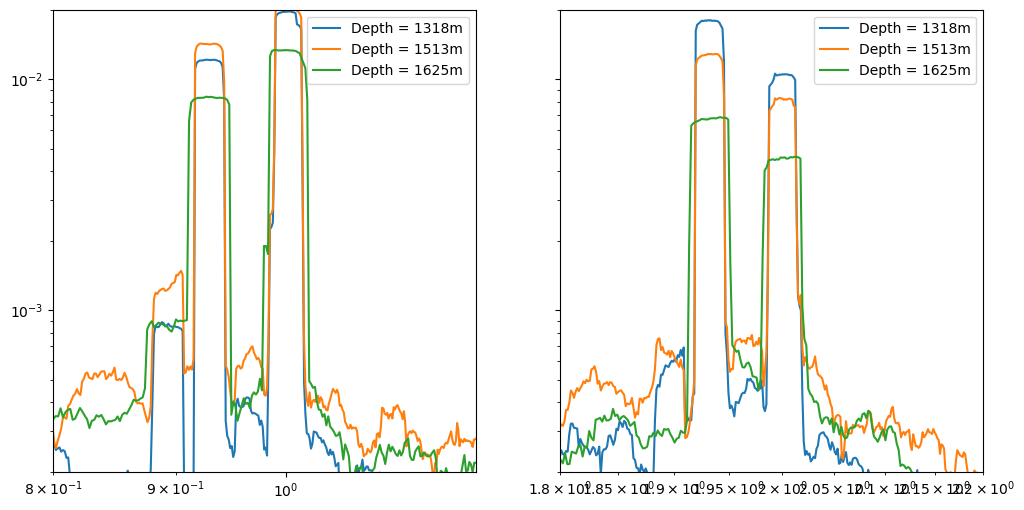

In [91]:
fig, ax = plt.subplots(ncols =2, sharey = True, figsize = (12,6))

mooring = list_of_moorings[1]
# iterate over all time series/columns in the mooring dataframe
for measurement_depth in mooring:
    if measurement_depth == "time":
        continue
    complex_velocity = mooring[measurement_depth]
    complex_velocity_array = helper.Data.cut_trailing_nans(
        complex_velocity.to_numpy()
    )
    freq, velocity_spectrum = spectra.total_multitaper(
        complex_velocity_array, dt=1 / 12, P=TIME_BANDWIDTH_PRODUCT
    )
    kinetic_psd = velocity_spectrum/2
    ax[0].loglog(freq, kinetic_psd, label = f"Depth = {measurement_depth}m")
    ax[1].loglog(freq, kinetic_psd, label = f"Depth = {measurement_depth}m")
    
ax[0].legend()
ax[0].set_xlim(0.8,1.2)
ax[1].legend()
ax[1].set_xlim(1.8,2.2)
ax[0].set_ylim(2e-4,2e-2)

But the depth dependence is not even the same for the diurnal and semidiurnal tides.

Let"s look at the other moorings:

In [92]:
SEMIDIURNAL_TIDAL_CONSTITUENTS = {"M2": 12.42}#, "S2": 12.00, "N2":12.66, "K2": 11.96,}
DIURNAL_TIDAL_CONSTITUENTS = {"K1": 23.93}#, "O1": 25.82, "P1":24.07, "Q1":26.87}

# sort the constituents in descending order after their tidal periods
# This is important for finding overlapping tidal peaks
SEMIDIURNAL_TIDAL_CONSTITUENTS = dict(sorted(SEMIDIURNAL_TIDAL_CONSTITUENTS.items(), key=lambda x: x[1], reverse=True))
DIURNAL_TIDAL_CONSTITUENTS = dict(sorted(DIURNAL_TIDAL_CONSTITUENTS.items(), key=lambda x: x[1], reverse=True))

Text(0.5, 1.0, 'Depth dependecy of tidal energy')

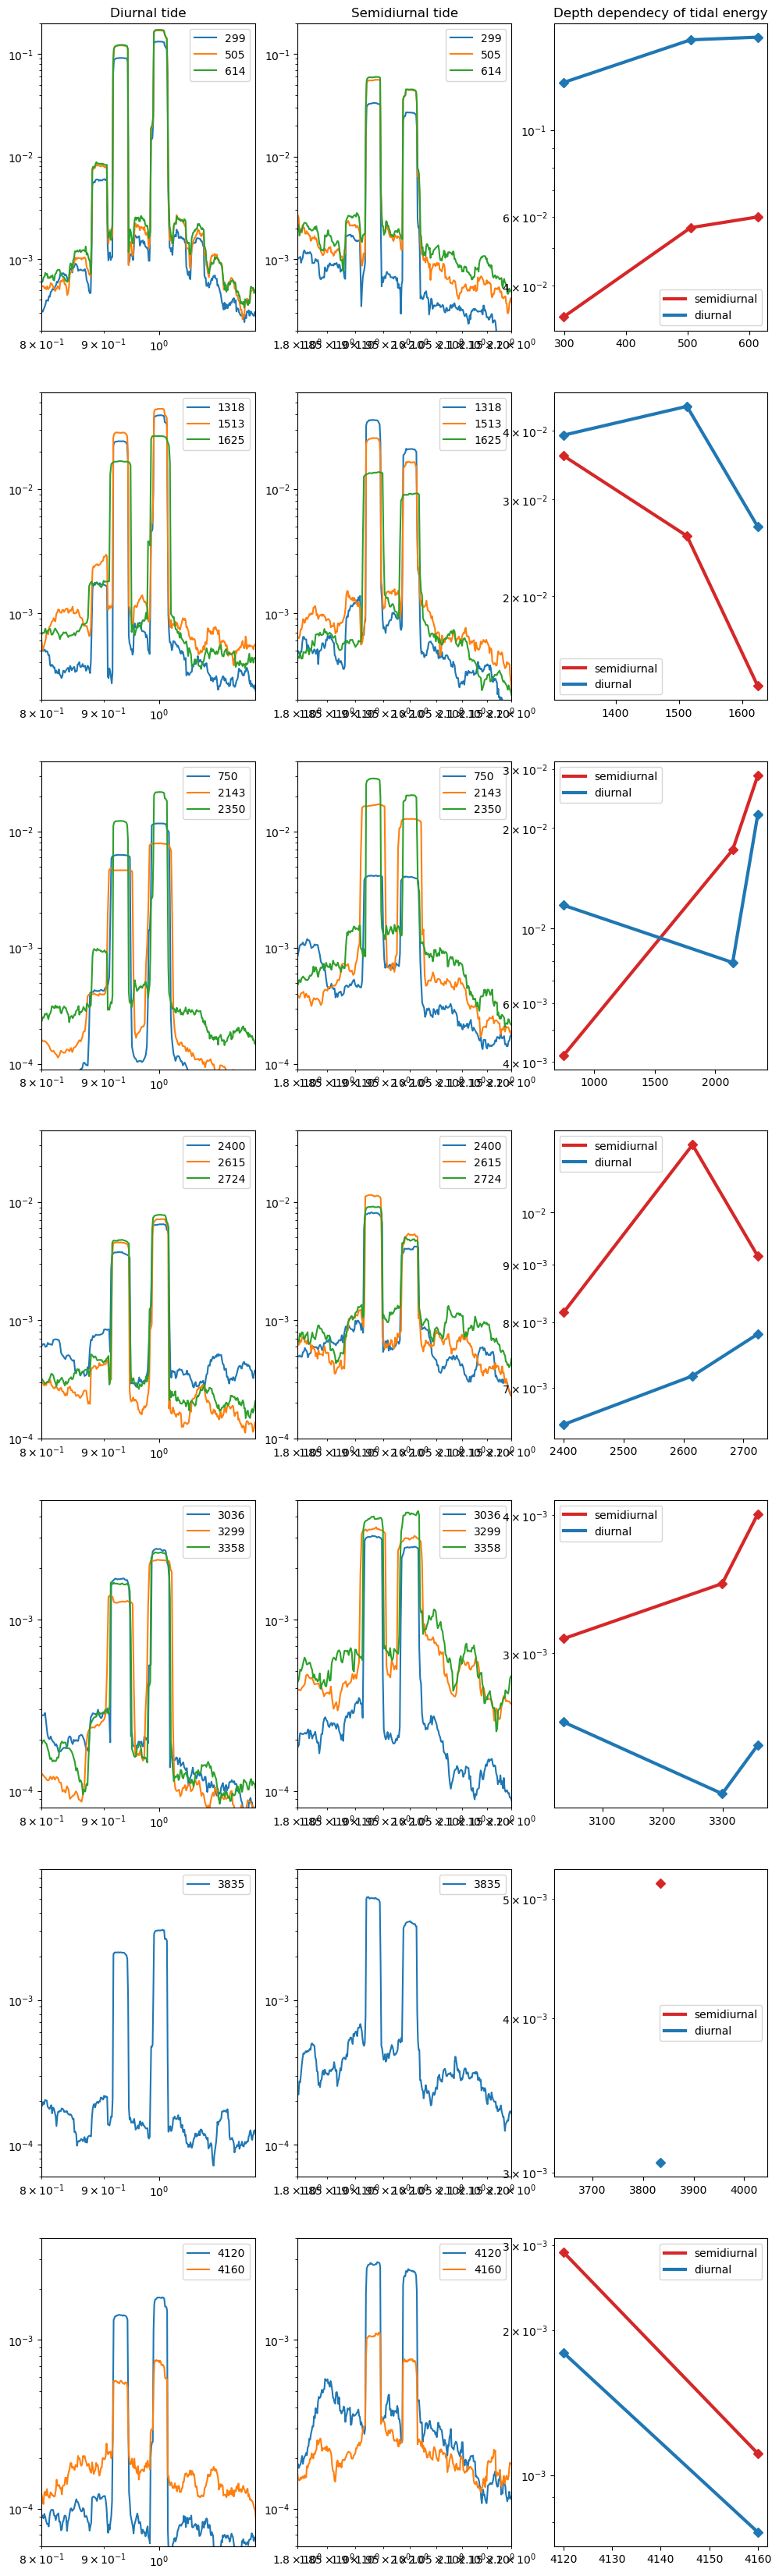

In [93]:
number_of_moorings = len(list_of_moorings)
fig, ax = plt.subplots(nrows = number_of_moorings, ncols =3, figsize = (12,number_of_moorings * 6))
for i,mooring in enumerate(list_of_moorings):
    
    semidiurnal_point_list = []
    diurnal_point_list = []
    
    # iterate over all time series/columns in the mooring dataframe
    for measurement_depth in sorted_nicely(mooring.columns):
        if measurement_depth == "time":
            continue
        complex_velocity = mooring[measurement_depth]
        complex_velocity_array = helper.Data.cut_trailing_nans(
            complex_velocity.to_numpy()
        )
        freq, kinetic_psd = spectra.total_multitaper(
            complex_velocity_array, dt=1 / 12, P=TIME_BANDWIDTH_PRODUCT
        )
        ax[i,0].loglog(freq, kinetic_psd, label = measurement_depth)
        ax[i,1].loglog(freq, kinetic_psd, label = measurement_depth)

        # calculate integration intervals for the tidal peaks
        semidiurnal_intervals = get_integration_intervals_for_tidal_peaks(
            freq, P=TIME_BANDWIDTH_PRODUCT, tidal_periods=SEMIDIURNAL_TIDAL_CONSTITUENTS.values()
        )
        diurnal_intervals = get_integration_intervals_for_tidal_peaks(
            freq, P=TIME_BANDWIDTH_PRODUCT, tidal_periods=DIURNAL_TIDAL_CONSTITUENTS.values()
        )
        for intervals, color in zip([semidiurnal_intervals, diurnal_intervals],["tab:red", "tab:blue"]):
            # iterate over the tidal peaks
            for interval_tuple in intervals:
                peak_height = max(
                    kinetic_psd[interval_tuple[0]:interval_tuple[1]]
                )
                #print(peak_height)
                ax[i,2].semilogy(int(measurement_depth),peak_height, "D", c=color)
                
                if color == "tab:red":
                    semidiurnal_point_list.append([int(measurement_depth),peak_height])
                else:       
                    diurnal_point_list.append([int(measurement_depth),peak_height])
                    
    semidiurnal_point_list = np.asarray(semidiurnal_point_list)
    diurnal_point_list = np.asarray(diurnal_point_list)
                    
    ax[i,2].semilogy(semidiurnal_point_list[:,0],semidiurnal_point_list[:,1], c = "tab:red", lw = 3, label = "semidiurnal")
    ax[i,2].semilogy(diurnal_point_list[:,0],diurnal_point_list[:,1], c = "tab:blue", lw = 3, label = "diurnal")
                    
    ax[i,0].legend()
    ax[i,1].legend()
    ax[i,2].legend()
    
    ax[i,0].set_xlim(0.8,1.2)
    ax[i,1].set_xlim(1.8,2.2)
    
for j in [0,1]:
    ax[0,j].set_ylim(2e-4,2e-1)
    ax[1,j].set_ylim(2e-4,6e-2)
    ax[2,j].set_ylim(9e-5,4e-2)
    ax[3,j].set_ylim(1e-4,4e-2)
    ax[4,j].set_ylim(8e-5,0.5e-2)
    ax[5,j].set_ylim(6e-5,8e-3)
    ax[6,j].set_ylim(6e-5,4e-3)
    
ax[0,0].set_title("Diurnal tide")    
ax[0,1].set_title("Semidiurnal tide")  
ax[0,2].set_title("Depth dependecy of tidal energy")  

# Compare tidal energy with other barotropic assumptions

In [98]:
ls ../data/CATS/

cats_barotropic_energies.pickle  cats_data.pickle  raw/


In [99]:
cats_df = pd.read_pickle("../data/CATS/cats_data.pickle")
#load barotropic energies from the CATS2008 model
barotropic_cats = cats_df.loc[:, cats_df.columns!='time'].abs().pow(2).mean()
cats_lons = [_[1] for _ in barotropic_cats.index.to_numpy()]

NameError: name 'longitudes' is not defined

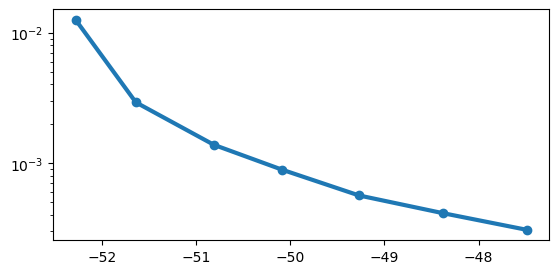

In [100]:
#errcalc = "wboot"
#out  = ttide.t_tide(xin = shallowest_complex_velocity, dt = 2, out_style = None, lat = mooring.location.lat, errcalc = errcalc)
#barotropic_uv = out["xout"].flatten()
#ttide_barotropic = np.var(fitted_barotropic_uv)

f,ax = plt.subplots(1,sharex = True, figsize = (6.4,3))
CATS_color = "#1f78b4"
integral_color = "black"
ttide_color = "#33a02c"
#ax[0].plot(cats_lons, barotropic_cats.values,"o-", c = CATS_color, label = "CATS")
#ax[0].plot(longitudes, integral_results,"o--", c = integral_color, label = "integral", zorder = 5)     
#ax[0].plot(longitudes, fit_results,"o:", c = ttide_color, label = "ttide")

ln1 = ax.semilogy(cats_lons, barotropic_cats.values,"o-", c = CATS_color, label = "CATS", lw =3)
ln2 = ax.semilogy(longitudes, integral_results,"o--", c = integral_color, label = "integral", zorder = 5, lw =3)     
ln3 = ax.semilogy(longitudes, fit_results,"o:", c = ttide_color, label = "ttide", lw =3) 

ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

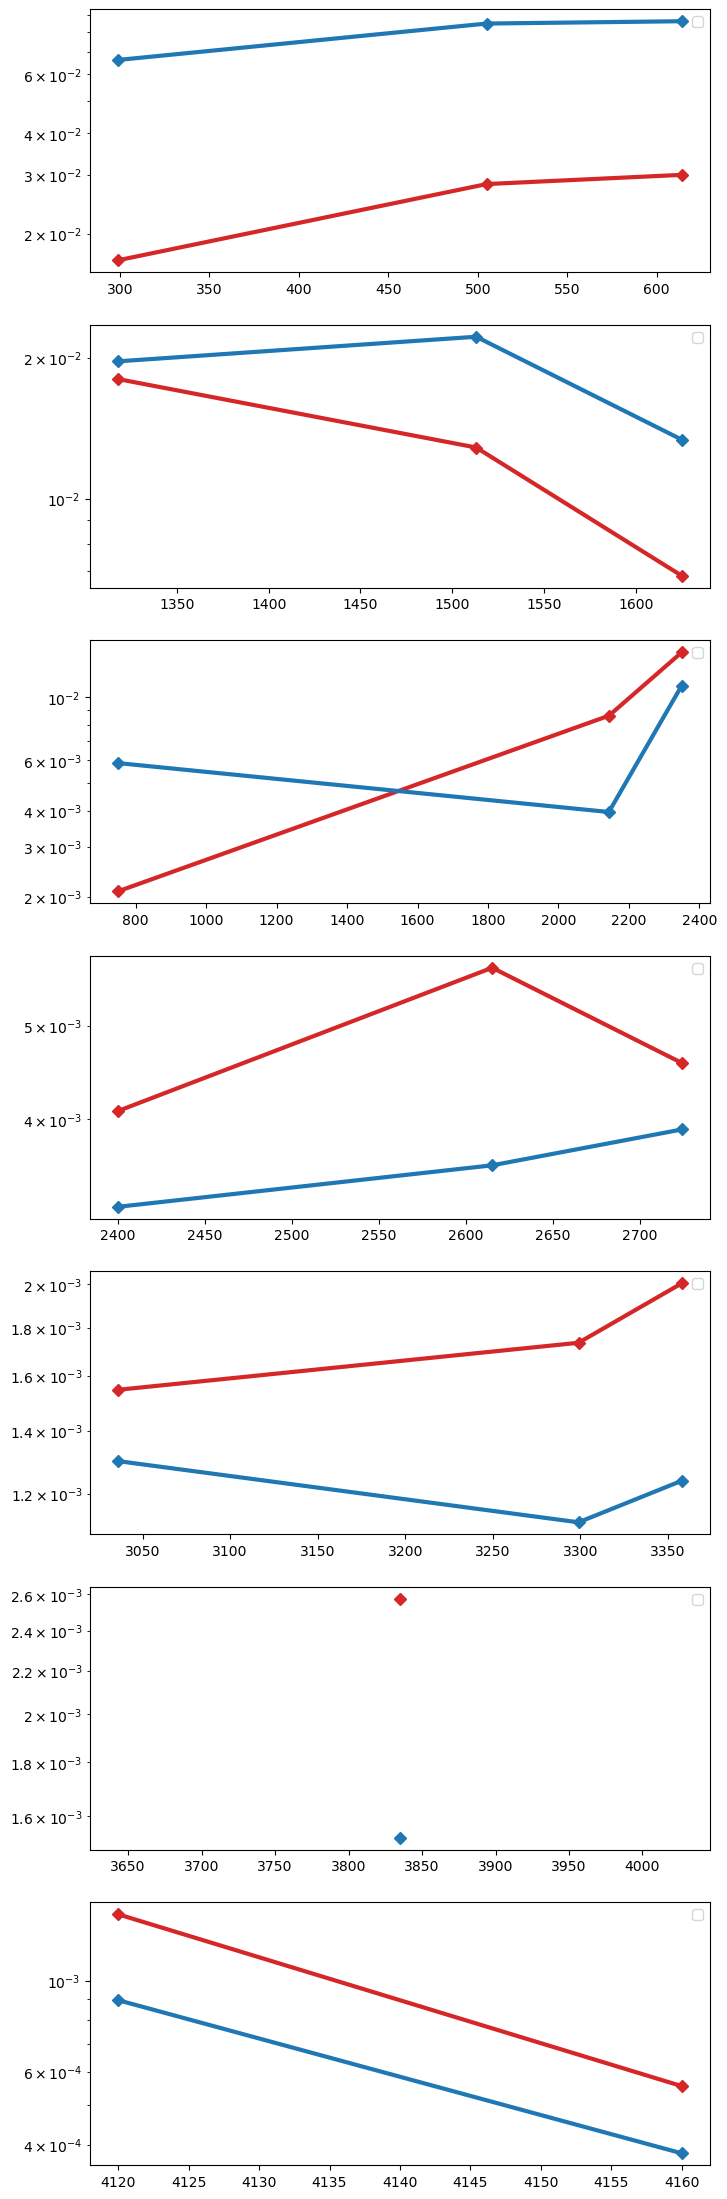

In [102]:
number_of_moorings = len(list_of_moorings)
fig, ax = plt.subplots(nrows = number_of_moorings, figsize = (8,number_of_moorings * 4))
for i,mooring in enumerate(list_of_moorings):
    
    semidiurnal_point_list = []
    diurnal_point_list = []
    
    # iterate over all time series/columns in the mooring dataframe
    for measurement_depth in sorted_nicely(mooring.columns):
        if measurement_depth == "time":
            continue
        complex_velocity = mooring[measurement_depth]
        complex_velocity_array = helper.Data.cut_trailing_nans(
            complex_velocity.to_numpy()
        )
        freq, velocity_spectrum = spectra.total_multitaper(
            complex_velocity_array, dt=1 / 12, P=TIME_BANDWIDTH_PRODUCT
        )
        kinetic_psd = velocity_spectrum/2
        
        # calculate integration intervals for the tidal peaks
        semidiurnal_intervals = get_integration_intervals_for_tidal_peaks(
            freq, P=TIME_BANDWIDTH_PRODUCT, tidal_periods=SEMIDIURNAL_TIDAL_CONSTITUENTS.values()
        )
        diurnal_intervals = get_integration_intervals_for_tidal_peaks(
            freq, P=TIME_BANDWIDTH_PRODUCT, tidal_periods=DIURNAL_TIDAL_CONSTITUENTS.values()
        )
        for intervals, color in zip([semidiurnal_intervals, diurnal_intervals],["tab:red", "tab:blue"]):
            # iterate over the tidal peaks
            for interval_tuple in intervals:
                peak_height = max(
                    kinetic_psd[interval_tuple[0]:interval_tuple[1]]
                )
                #print(peak_height)
                ax[i].semilogy(int(measurement_depth),peak_height, "D", c=color)
                
                if color == "tab:red":
                    semidiurnal_point_list.append([int(measurement_depth),peak_height])
                else:       
                    diurnal_point_list.append([int(measurement_depth),peak_height])
                    
    semidiurnal_point_list = np.asarray(semidiurnal_point_list)
    diurnal_point_list = np.asarray(diurnal_point_list)
                    
    ax[i].semilogy(semidiurnal_point_list[:,0],semidiurnal_point_list[:,1], c = "tab:red", lw = 3)
    ax[i].semilogy(diurnal_point_list[:,0],diurnal_point_list[:,1], c = "tab:blue", lw = 3)
                    
    ax[i].legend()

{'M2': 12.42, 'S2': 12.0, 'N2': 12.66, 'K2': 11.96}
Mooring 0, shallowest measurement at 299m depth
[1.15025752e-06 4.60102212e-06 1.03522700e-05 ... 2.01263683e+00
 2.01280911e+00 2.01298139e+00]


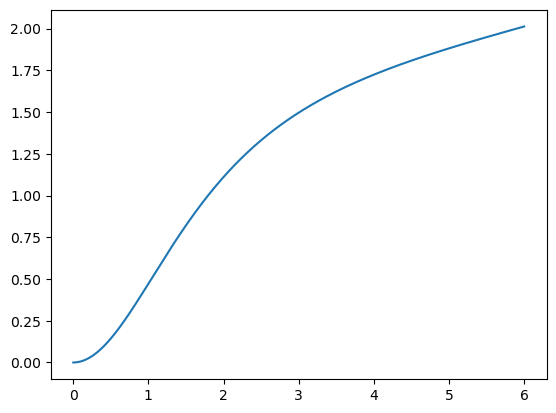

AssertionError: 

In [107]:
tidal_constits = helper.Constants.get_tidal_frequencies_in_hours()
print(tidal_constits)
# sort the constituents in descending order after their tidal periods
# This is important for finding overlapping tidal peaks
tidal_constits = dict(sorted(tidal_constits.items(), key=lambda x: x[1], reverse=True))

TIME_BANDWIDTH_PRODUCT = 10

barotropic_energies = []
baroclinic_energies = []
IW_energies = []
latitudes = []
longitudes = []
depths = []

for nr, mooring in enumerate(list_of_moorings):

    UPPER_INTEGRATION_BOUND_IN_CPD = 10

    # == barotropic tidal energy ==
    barotropic_energy_between_f_and_N = 0  # need for the IW energy later

    # pick the shallowest velocity time series
    shallowest_complex_velocity = mooring.oze.get_shallowest_time_series()
    shallowest_depth = shallowest_complex_velocity.name
    print(f"Mooring {nr}, shallowest measurement at {shallowest_depth}m depth")
    shallowest_complex_velocity_array = helper.Data.cut_trailing_nans(
        shallowest_complex_velocity.to_numpy()
    )

    # calculated kinetic energy spectrum
    shallowest_freq, shallowest_kinetic_psd = spectra.total_multitaper(
        shallowest_complex_velocity_array, dt=1 / 12, P=TIME_BANDWIDTH_PRODUCT
    )
    assert not np.any(np.isnan(shallowest_kinetic_psd))


    # get instrument depth in units of meter above the sea floor
    mab_of_measurement = int(max_depth_dict[mooring.location.lon]) - int(shallowest_depth) 
    #print("Shallow Test:",mab_of_measurement)
    
    """
    # if measurement is too far up into the water column, log and skip it
    if mab_of_measurement > 500:
        print(f"Too far away from the sea floor: {mooring.location.lon}, {mab_of_measurement} mab.")
        continue
    """
    
    if mab_of_measurement < 0 and mab_of_measurement > -2:
        print(f"Instrument depth was corrected from {mab_of_measurement} to 0 mab.")
        mab_of_measurement = 0
        
    # get N value at the geographic locations and depths of the velocity measurement
    # column in N_table is fixed by the mooring latitude, row by the measurement_depth
    column_name = f"({mooring.location.lat:.2f},{mooring.location.lon:.2f})"    
    avrg_N_in_rads = N_table.loc[
        N_table["mab"] == mab_of_measurement, column_name
    ].item()

    coriolis_frequency_in_rads = helper.Constants.get_coriolis_frequency(
        mooring.location.lat, unit="rad/s", absolute=True
    )
    coriolis_frequency_in_cpd = helper.Constants.get_coriolis_frequency(
        mooring.location.lat, unit="cpd", absolute=True
    )
    avrg_N_in_cpd = avrg_N_in_rads /(2*np.pi) *86400

    # Correction factor in cpd
    kinetic_to_total_energy_factor = kinetic_to_total_energy(
        N=avrg_N_in_cpd, f=coriolis_frequency_in_cpd, omega = shallowest_freq
    )
    
    print(kinetic_to_total_energy_factor)
    plt.plot(shallowest_freq,kinetic_to_total_energy_factor)
    plt.show()
    assert np.all(kinetic_to_total_energy_factor > 1)
    
    # Compare to Correction factor in rad/s
    difference = kinetic_to_total_energy_factor - kinetic_to_total_energy(
        N=avrg_N_in_rads, f=coriolis_frequency_in_rads, omega = shallowest_freq * 2*np.pi / 86400)
    assert np.all(np.abs(difference) < 1e-15)
    
    # convert kinetic to total (kinetic+potential) energy    
    # PSD and the frequency is in units of cpd
    shallowest_total_psd = kinetic_to_total_energy_factor * shallowest_kinetic_psd
 

    # calculate integration intervals for the tidal peaks
    barotropic_energy_per_peak = []
    integration_indices_intervals = get_integration_intervals_for_tidal_peaks(
        shallowest_freq, P=TIME_BANDWIDTH_PRODUCT, tidal_periods=tidal_constits.values()
    )
    # iterate over each peak and subtract the background energy, which is here simply calculated as box
    for interval_tuple in integration_indices_intervals:
        a = shallowest_freq[interval_tuple[0]]
        b = shallowest_freq[interval_tuple[1]]
        peak_integral = spectra.integrate_psd_interval(
            shallowest_freq, shallowest_total_psd, a=a, b=b
        )
        background_height = min(
            shallowest_total_psd[interval_tuple[0]],
            shallowest_total_psd[interval_tuple[1]],
        )
        background_integral = background_height * (b - a)
        barotropic_energy_per_peak.append(peak_integral - background_integral)

        # if the peak falls between f and N, is has to be later subtracted
        # from the total integral from f to N to obtain the IW energy
        if shallowest_freq[interval_tuple[0]] > coriolis_frequency_in_cpd:
            barotropic_energy_between_f_and_N += peak_integral - background_integral

    # TODO
    fig, ax = plt.subplots(1)
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    axins = inset_axes(ax, width="30%", height="50%", loc=3, borderpad=1)
    axins.vlines(
        helper.Constants.get_coriolis_frequency(
            mooring.location.lat, unit="cpd", absolute=True
        ),
        1e-6,
        1e-1,
        color="k",
        alpha=0.5,
        linestyle="-",
        linewidth=0.75,
    )
    axins.text(1.78, 0.4 * 1e-3, "f", color="k", alpha=0.5)
    axins.vlines(
        24 / 12.4, 1e-6, 1e-1, color="k", alpha=0.5, linestyle="-", linewidth=0.75
    )
    axins.text(1.94, 0.35 * 1e-3, "M2", color="k", alpha=0.5)
    # Turn ticklabels of insets off
    axins.tick_params(
        axis="both",
        which="both",
        labelleft=False,
        labelbottom=False,
        left=False,
        bottom=False,
    )

    # iterate over all time series/columns in the mooring dataframe
    for measurement_depth in mooring:
        if measurement_depth == "time":
            continue

        # == total tidal energy ==
        tidal_energy_between_f_and_N = 0
        print(f"\tmeasurement at {measurement_depth}m")
        complex_velocity = mooring[measurement_depth]
        complex_velocity_array = help.Data.cut_trailing_nans(
            complex_velocity.to_numpy()
        )
        freq, velocity_spectrum = spectra.total_multitaper(
            complex_velocity_array, dt=1 / 12, P=TIME_BANDWIDTH_PRODUCT
        )
        kinetic_psd = velocity_spectrum/2
        assert not np.any(np.isnan(total_psd))

        # convert kinetic to total (kinetic+potential) energy
        # get N value at the geographic locations and depths of the velocity measurement
        # column in N_table is fixed by the mooring latitude, row by the measurement_depth

        # get instrument depth in units of meter above the sea floor
        mab_of_measurement = int(max_depth_dict[mooring.location.lon]) - int(measurement_depth) 
        #print("Test:",mab_of_measurement)

        """"
        # if measurement is too far up into the water column, log and skip it
        if mab_of_measurement > 500:
            print(f"Too far away from the sea floor: {mooring.location.lon}, {mab_of_measurement} mab.")
            #continue
        """

        if mab_of_measurement < 0 and mab_of_measurement > -2:
            print(f"Instrument depth was corrected from {mab_of_measurement} to 0 mab.")
            mab_of_measurement = 0

        column_name = f"({mooring.location.lat:.2f},{mooring.location.lon:.2f})"    
        avrg_N_in_rads = N_table.loc[
            N_table["mab"] == mab_of_measurement, column_name
        ].item()

        #print(f"{mooring.location.lon},{mab_of_measurement},{avrg_N_in_rads=}")

        coriolis_frequency_in_rads = helper.Constants.get_coriolis_frequency(
            mooring.location.lat, unit="rad/s", absolute=True
        )
        coriolis_frequency_in_cpd = helper.Constants.get_coriolis_frequency(
            mooring.location.lat, unit="cpd", absolute=True
        )
        avrg_N_in_cpd = avrg_N_in_rads /(2*np.pi) *86400

        # Correction factor in cpd
        kinetic_to_total_energy_factor = kinetic_to_total_energy(
            N=avrg_N_in_cpd, f=coriolis_frequency_in_cpd, omega = freq
        )


        assert np.all(kinetic_to_total_energy_factor > 1)

        # Compare to Correction factor in rad/s
        difference = kinetic_to_total_energy_factor - kinetic_to_total_energy(
            N=avrg_N_in_rads, f=coriolis_frequency_in_rads, omega = freq * 2*np.pi / 86400
        )
        assert np.all(np.abs(difference) < 1e-15)


        # PSD and the frequency is in units of cpd
        total_psd = kinetic_to_total_energy_factor * kinetic_psd



        tidal_energy_per_peak = []
        # calculate integration intervals for the tidal peaks
        integration_indices_intervals = get_integration_intervals_for_tidal_peaks(
            freq, P=TIME_BANDWIDTH_PRODUCT, tidal_periods=tidal_constits.values()
        )

        # iterate over the tidal peaks
        for interval_tuple in integration_indices_intervals:
            a = freq[interval_tuple[0]]
            b = freq[interval_tuple[1]]
            peak_integral = spectra.integrate_psd_interval(
                freq, total_psd, a=a, b=b
            )
            background_height = min(
                total_psd[interval_tuple[0]], total_psd[interval_tuple[1]]
            )
            background_integral = background_height * (b - a)
            tidal_energy_per_peak.append(peak_integral - background_integral)

            # TODO#axins.plot([a,b],2*[background_height],"k", zorder = 10)

            # if the peak falls between f and N, is has to be later subtracted
            # from the total integral from f to N to obtain the IW energy
            if freq[interval_tuple[0]] > coriolis_frequency_in_cpd:
                tidal_energy_between_f_and_N += peak_integral - background_integral

        # TODO
        ax.loglog(freq, total_psd, label=measurement_depth)
        axins.loglog(freq, total_psd)

        # == Internal wave energy ==
        # integrate spectrum from f to N
        spectral_energy = help.Spectrum.integrate_psd_interval(
            freq, total_psd, a=coriolis_frequency_in_cpd, b= UPPER_INTEGRATION_BOUND_IN_CPD
        )
        # subtract the energy from the peaks
        IW_energy = spectral_energy - tidal_energy_between_f_and_N
        # Sanity check: Internal wave energy should always be greater 0
        assert IW_energy > 0

        # go from the energies per peak to the total energy per time series
        barotropic_energy = np.sum(barotropic_energy_per_peak)
        baroclinic_energy = np.sum(tidal_energy_per_peak) - barotropic_energy
        if baroclinic_energy == 0:
            baroclinic_energy = np.nan

        # every energy level is for a individual time series
        # add levels to lists to they can be saved later together as file
        barotropic_energies.append(barotropic_energy)
        baroclinic_energies.append(baroclinic_energy)
        IW_energies.append(IW_energy)
        latitudes.append(mooring.location.lat)
        longitudes.append(mooring.location.lon)
        depths.append(measurement_depth)

    help.Plot.add_tidal_and_f_ticks(ax, coriolis_frequency_in_cpd)
    axins.set_xbound(1.73, 2.1)
    axins.set_ybound(3 * 1e-4, 0.08)
    ax.legend()
    ax.set_title(f"Mooring {nr} at {mooring.location.pretty_print()}")
    ax.set_xlabel("Frequency (cycles/day)")
    ax.set_ylabel("PSD (m$^2$/s$^2$ days)")
    fig.tight_layout()
    #plt.savefig(f"./figures/Mooring{nr}", dpi=300)
    # plt.show()


